In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datacompy
import os
import numpy as np
from joblib import dump, load
import pickle
from scipy.io import arff

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder

# modele + Smote
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler, EditedNearestNeighbours, TomekLinks, NeighbourhoodCleaningRule, InstanceHardnessThreshold, OneSidedSelection, CondensedNearestNeighbour
from ctgan import CTGAN

In [2]:
# dataset.py.df()
df = pd.read_csv("D:/ml/xgboost-main/data/ssh_logs/SSH.csv")
df = df.drop(columns=["user", "ts"])
print(df.columns)
df = df.drop_duplicates()

Index(['is_private', 'is_failure', 'is_root', 'is_valid', 'not_valid_count',
       'ip_failure', 'ip_success', 'no_failure', 'first', 'td', 'target'],
      dtype='object')


In [4]:
y = df["target"]
X = df.drop(columns=["target"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

df_train = pd.concat([X_train, y_train], axis=1) 
df_train['source'] = 'original' 
df_train .to_csv("D:\\ml\\xgboost-main\\data\\ssh_logs\\original_data.csv")

y_test.to_csv("D:\\ml\\xgboost-main\\data\\ssh_logs\\y_test.csv")
X_test.to_csv("D:\\ml\\xgboost-main\\data\\ssh_logs\\X_test.csv")

Przed Counter({0: 163, 1: 53})
Po Counter({0: 163, 1: 163})
(326, 10) (326,)


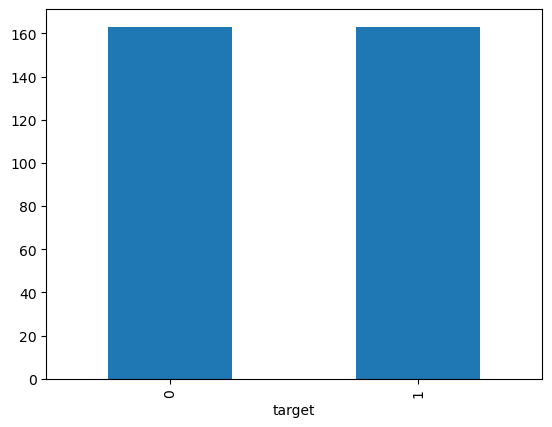

In [6]:
file_path1 = "D:\\ml\\xgboost-main\\data\\ssh_logs\\smote_data.csv"
#generate new data by SMOTE
con = Counter(y_train)
print("Przed", con)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
con1 = Counter(y_train_sm)
print("Po", con1)

#concat smote train X & y && save data
train_data_smote = pd.concat([X_train_sm, y_train_sm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_smote['generated_by_smote'] = ['original' if i < len(df_train) else 'smote' for i in range(len(train_data_smote))]
smote_data = train_data_smote[train_data_smote['generated_by_smote'] == 'smote'].drop('generated_by_smote', axis=1)
smote_data["source"]="smote"

if not os.path.exists(file_path1):
    smote_data.to_csv(file_path1, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path1}')

pd.Series(y_train_sm).value_counts().plot.bar()
print(X_train_sm.shape, y_train_sm.shape)

Przed Counter({0: 163, 1: 53})
Po Counter({0: 163, 1: 163})
(326, 10) (326,)


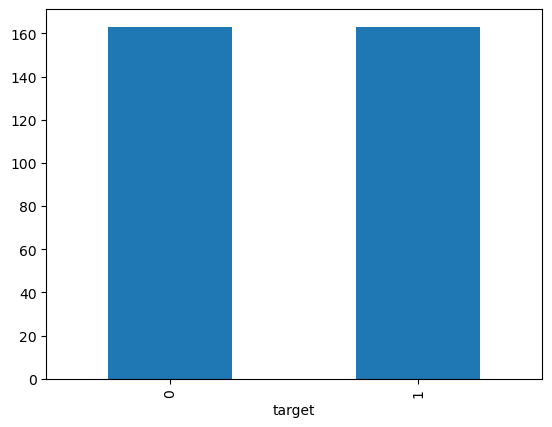

In [8]:
file_path2 = "D:\\ml\\xgboost-main\\data\\ssh_logs\\borderlinesmote_data.csv"
#generate new data by borderLineSMOTE
con3 = Counter(y_train)
print("Przed", con3)
brdsmote = BorderlineSMOTE(random_state=42)
X_train_bsm, y_train_bsm = brdsmote.fit_resample(X_train, y_train)
con4 = Counter(y_train_bsm)
print("Po", con4)

train_data_borderline_smote = pd.concat([X_train_bsm, y_train_bsm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_borderline_smote['generated_by_borderline_smote'] = ['original' if i < len(df_train) else 'brd smote' for i in range(len(train_data_borderline_smote))]
boarderline_smote_data = train_data_borderline_smote[train_data_borderline_smote['generated_by_borderline_smote'] == 'brd smote'].drop('generated_by_borderline_smote', axis=1)
boarderline_smote_data["source"]="borderline smote"
if not os.path.exists(file_path2):
    boarderline_smote_data.to_csv(file_path2, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path2}')

pd.Series(y_train_bsm).value_counts().plot.bar()
print(X_train_bsm.shape, y_train_bsm.shape)

Dane wygenerowane:  target
1    110
Name: count, dtype: int64
Before Counter({0: 163, 1: 53})
After Counter({0: 163, 1: 163})


<Axes: xlabel='target'>

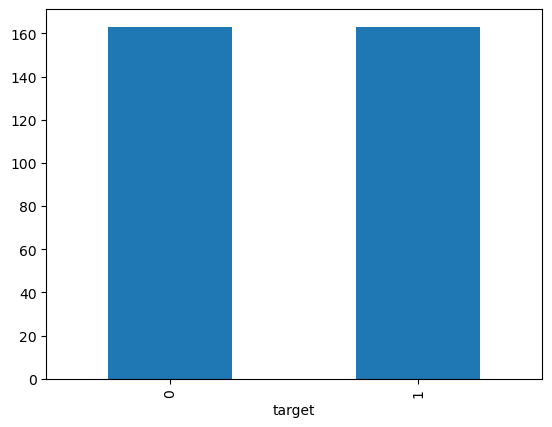

In [11]:
file_path3 = "D:\\ml\\xgboost-main\\data\\ssh_logs\\GAN_data.csv"        #sciezka wraz z nazwa pod jaka wygenerowac plik
#generate new data by GAN
columns_list = df_train.columns
target_num = df_train['target'].value_counts()
ctgan = CTGAN(epochs=10)        #model

if target_num[0] > target_num[1]:
    data_y1 = df_train[df_train['target']==1]
    ctgan.fit(data_y1, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['target'].value_counts())
    balanced_data = pd.concat([df_train, df_GAN], ignore_index=False)
else:
    data_y0 = df_train[df_train['target']==0]
    ctgan.fit(data_y0, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['target'].value_counts())
    balanced_data = pd.concat([df_train, df_GAN], ignore_index=False)

balanced_data = balanced_data.drop(columns=["source"])  
y_train_gan = balanced_data["target"]
X_train_gan = balanced_data.drop(columns=["target"])
con5 = Counter(y_train)
print("Before", con5)
con6 = Counter(y_train_gan)
print("After", con6)
df_GAN["source"]="gan"
gan_data = df_GAN
if not os.path.exists(file_path3):
    gan_data.to_csv(file_path3, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path3}')

pd.Series(y_train_gan).value_counts().plot.bar()

In [14]:
models = {
    
    "LR": LogisticRegression(random_state=0, max_iter=100),             # logistic regression dla niezbalansowanych 
    "LR_SMOTE": LogisticRegression(random_state=0, max_iter=100),       # logistic regression dla zbalansowanych SMOTE
    "LR_BrdSMOTE": LogisticRegression(random_state=0, max_iter=100),    # logistic regression dla zbalansowanych BoarderrLineSMOTE
    "LR_GAN": LogisticRegression(random_state=0, max_iter=500),         # logistic regression dla zbalansowanych GAN
    
    "DT": DecisionTreeClassifier(max_depth=6, min_samples_leaf=1, random_state=10),             # decision tree dla niezbalansowanych
    "DT_SMOTE": DecisionTreeClassifier(max_depth=6, min_samples_leaf=1, random_state=10),       # decision tree dla zbalansowanych SMOTE
    "DT_BrdSMOTE": DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=0),     # decision tree dla zbalansowanych BoarderrLineSMOTE
    "DT_GAN": DecisionTreeClassifier(max_depth=8, min_samples_leaf=1, random_state=0),          # decision tree dla zbalansowanych GAN
    
    "RF": RandomForestClassifier(n_estimators=20, max_depth=6, min_samples_leaf=1, random_state=0),             # random forest dla niezbalansowanych
    "RF_SMOTE": RandomForestClassifier(n_estimators=20, max_depth=6, min_samples_leaf=1, random_state=0),       # random forest dla zbalansowanych SMOTE
    "RF_BrdSMOTE": RandomForestClassifier(n_estimators=20, max_depth=4, min_samples_leaf=1, random_state=0),    # random forest dla zbalansowanych BoarderrLineSMOTE
    "RF_GAN": RandomForestClassifier(n_estimators=60, max_depth=8, min_samples_leaf=1, random_state=30),        # random forest dla zbalansowanych GAN
    
    "XGB": XGBClassifier(max_depth=4, subsample=0.6),           # xgboost dla niezbalansowanych
    "XGB_SMOTE": XGBClassifier(max_depth=4, subsample=0.5),     # xgboost dla zbalansowanych SMOTE
    "XGB_BrdSMOTE": XGBClassifier(max_depth=4, subsample=1),    # xgboost dla zbalansowanych BoarderrLineSMOTE
    "XGB_GAN": XGBClassifier(max_depth=4, subsample=0.7),       # xgboost dla zbalansowanych GAN
    
    "XGB_RF": XGBRFClassifier(n_estimators=20, max_depth=4, subsample=0.9, random_state=10),            # xgboost rf dla niezbalansowanych
    "XGB_RF_SMOTE": XGBRFClassifier(n_estimators=20, max_depth=4, subsample=1, random_state=0),         # xgboost rf dla zbalansowanych SMOTE
    "XGB_RF_BrdSMOTE": XGBRFClassifier(n_estimators=20, max_depth=4, subsample=0.9, random_state=10),   # xgboost rf dla zbalansowanych BoarderrLineSMOTE
    "XGB_RF_GAN": XGBRFClassifier(n_estimators=40, max_depth=4, subsample=0.6, random_state=0)          # xgboost rf dla zbalansowanych GAN
}

fit_data = {
    
    "LR": (X_train, y_train),
    "LR_SMOTE": (X_train_sm, y_train_sm),
    "LR_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "LR_GAN": (X_train_gan, y_train_gan),
    
    "DT": (X_train, y_train),
    "DT_SMOTE": (X_train_sm, y_train_sm),
    "DT_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "DT_GAN": (X_train_gan, y_train_gan),
    
    "RF": (X_train, y_train),
    "RF_SMOTE": (X_train_sm, y_train_sm),
    "RF_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "RF_GAN": (X_train_gan, y_train_gan),
    
    "XGB": (X_train, y_train),
    "XGB_SMOTE": (X_train_sm, y_train_sm),
    "XGB_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "XGB_GAN": (X_train_gan, y_train_gan),

    "XGB_RF": (X_train, y_train),
    "XGB_RF_SMOTE": (X_train_sm, y_train_sm),
    "XGB_RF_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "XGB_RF_GAN": (X_train_gan, y_train_gan)
}

In [15]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
results_cross_mean=[]
results_cross_std=[]
goal = ['precision','f1','recall','accuracy']
path_files = ["D:\\ml\\xgboost-main\\reports\\ssh\\precision_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\ssh\\f1_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\ssh\\recall_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\ssh\\accuracy_metrics.txt"]

excel_file_cross = "D:\\ml\\xgboost-main\\reports\\ssh\\cross.xlsx"
excel_file_cross2 = "D:\\ml\\xgboost-main\\reports\\ssh\\cross_std.xlsx"
name_sheet1 = "Arkusz1"

#if not exist -> create
if not os.path.exists(excel_file_cross):
    empty_df = pd.DataFrame()
    empty_df.to_csv(excel_file_cross, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {excel_file_cross}')
        
if not os.path.exists(excel_file_cross2):
    empty_df = pd.DataFrame()
    empty_df.to_csv(excel_file_cross2, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {excel_file_cross2}')

for metrix1, path_file in zip(goal, path_files):
    for model_name, model in models.items():
        
        X_train, y_train = fit_data[model_name]
        cross_val_results = cross_val_score(model, X_train, y_train, cv=cv, scoring=metrix1, n_jobs=1)
        print(f"Learn: {metrix1} and model {model_name}")
        with open(path_file, "a+") as f:
            # Zapis wyników do pliku
            print(f'{model_name} Cross-Validation Results {metrix1}:\n {cross_val_results}', file=f)
            print(f'Mean {metrix1}: {cross_val_results.mean()}', file=f)
            print(f'Dev: {cross_val_results.std()}', file=f)
            print("\n", file=f)

        
        results_cross_mean.append({
        "Model": model_name,
        "Metric": metrix1,
        "Result": cross_val_results.mean()})
        results_cross_std.append({
        "Model": model_name,
        "Metric": metrix1,
        "Std": cross_val_results.std()})
        df_results_cross_mean = pd.DataFrame(results_cross_mean)
        df_results_cross_std = pd.DataFrame(results_cross_std)
        df_save_mean = df_results_cross_mean.pivot(index="Metric", columns="Model", values="Result")
        df_save_std = df_results_cross_std.pivot(index="Metric", columns="Model", values="Std")
        
        with pd.ExcelFile(excel_file_cross) as w:
            df_save_mean.to_excel(w, sheet_name=name_sheet1)
        with pd.ExcelFile(excel_file_cross2) as w1:
            df_save_std.to_excel(w1, sheet_name=name_sheet1)

Plik istnieje pod ścieżką: D:\ml\xgboost-main\reports\ssh\cross.xlsx
Plik istnieje pod ścieżką: D:\ml\xgboost-main\reports\ssh\cross_std.xlsx


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_SMOTE


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_BrdSMOTE


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_GAN
Learn: precision and model DT
Learn: precision and model DT_SMOTE
Learn: precision and model DT_BrdSMOTE
Learn: precision and model DT_GAN
Learn: precision and model RF
Learn: precision and model RF_SMOTE
Learn: precision and model RF_BrdSMOTE
Learn: precision and model RF_GAN
Learn: precision and model XGB
Learn: precision and model XGB_SMOTE
Learn: precision and model XGB_BrdSMOTE
Learn: precision and model XGB_GAN
Learn: precision and model XGB_RF
Learn: precision and model XGB_RF_SMOTE
Learn: precision and model XGB_RF_BrdSMOTE
Learn: precision and model XGB_RF_GAN


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_SMOTE


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_BrdSMOTE


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_GAN
Learn: f1 and model DT
Learn: f1 and model DT_SMOTE
Learn: f1 and model DT_BrdSMOTE
Learn: f1 and model DT_GAN
Learn: f1 and model RF
Learn: f1 and model RF_SMOTE
Learn: f1 and model RF_BrdSMOTE
Learn: f1 and model RF_GAN
Learn: f1 and model XGB
Learn: f1 and model XGB_SMOTE
Learn: f1 and model XGB_BrdSMOTE
Learn: f1 and model XGB_GAN
Learn: f1 and model XGB_RF
Learn: f1 and model XGB_RF_SMOTE
Learn: f1 and model XGB_RF_BrdSMOTE
Learn: f1 and model XGB_RF_GAN


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_SMOTE


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_BrdSMOTE


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_GAN
Learn: recall and model DT
Learn: recall and model DT_SMOTE
Learn: recall and model DT_BrdSMOTE
Learn: recall and model DT_GAN
Learn: recall and model RF
Learn: recall and model RF_SMOTE
Learn: recall and model RF_BrdSMOTE
Learn: recall and model RF_GAN
Learn: recall and model XGB
Learn: recall and model XGB_SMOTE
Learn: recall and model XGB_BrdSMOTE
Learn: recall and model XGB_GAN
Learn: recall and model XGB_RF
Learn: recall and model XGB_RF_SMOTE
Learn: recall and model XGB_RF_BrdSMOTE
Learn: recall and model XGB_RF_GAN


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_SMOTE


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_BrdSMOTE


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_GAN
Learn: accuracy and model DT
Learn: accuracy and model DT_SMOTE
Learn: accuracy and model DT_BrdSMOTE
Learn: accuracy and model DT_GAN
Learn: accuracy and model RF
Learn: accuracy and model RF_SMOTE
Learn: accuracy and model RF_BrdSMOTE
Learn: accuracy and model RF_GAN
Learn: accuracy and model XGB
Learn: accuracy and model XGB_SMOTE
Learn: accuracy and model XGB_BrdSMOTE
Learn: accuracy and model XGB_GAN
Learn: accuracy and model XGB_RF
Learn: accuracy and model XGB_RF_SMOTE
Learn: accuracy and model XGB_RF_BrdSMOTE
Learn: accuracy and model XGB_RF_GAN


In [16]:
for model_name, model in models.items():  
    name = f"D:\\ml\\xgboost-main\\models\\ssh\\{model_name}.joblib"  
    dump(model, name)
    print(f"Model {model_name} saved in: {name}")

Model LR saved in: D:\ml\xgboost-main\models\ssh\LR.joblib
Model LR_SMOTE saved in: D:\ml\xgboost-main\models\ssh\LR_SMOTE.joblib
Model LR_BrdSMOTE saved in: D:\ml\xgboost-main\models\ssh\LR_BrdSMOTE.joblib
Model LR_GAN saved in: D:\ml\xgboost-main\models\ssh\LR_GAN.joblib
Model DT saved in: D:\ml\xgboost-main\models\ssh\DT.joblib
Model DT_SMOTE saved in: D:\ml\xgboost-main\models\ssh\DT_SMOTE.joblib
Model DT_BrdSMOTE saved in: D:\ml\xgboost-main\models\ssh\DT_BrdSMOTE.joblib
Model DT_GAN saved in: D:\ml\xgboost-main\models\ssh\DT_GAN.joblib
Model RF saved in: D:\ml\xgboost-main\models\ssh\RF.joblib
Model RF_SMOTE saved in: D:\ml\xgboost-main\models\ssh\RF_SMOTE.joblib
Model RF_BrdSMOTE saved in: D:\ml\xgboost-main\models\ssh\RF_BrdSMOTE.joblib
Model RF_GAN saved in: D:\ml\xgboost-main\models\ssh\RF_GAN.joblib
Model XGB saved in: D:\ml\xgboost-main\models\ssh\XGB.joblib
Model XGB_SMOTE saved in: D:\ml\xgboost-main\models\ssh\XGB_SMOTE.joblib
Model XGB_BrdSMOTE saved in: D:\ml\xgboost-m

### Heat Map

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


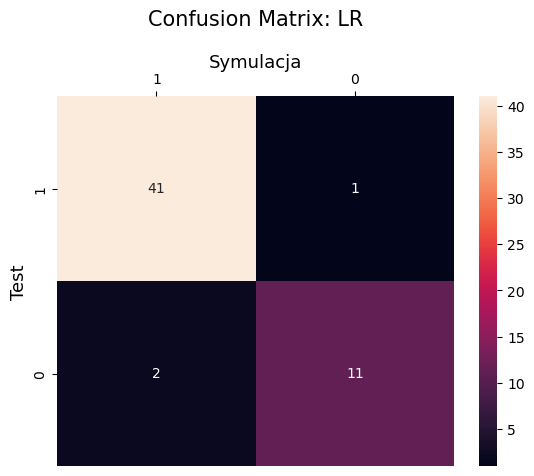

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


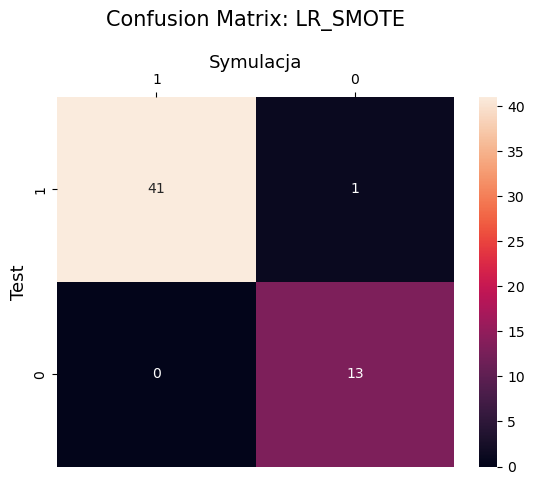

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


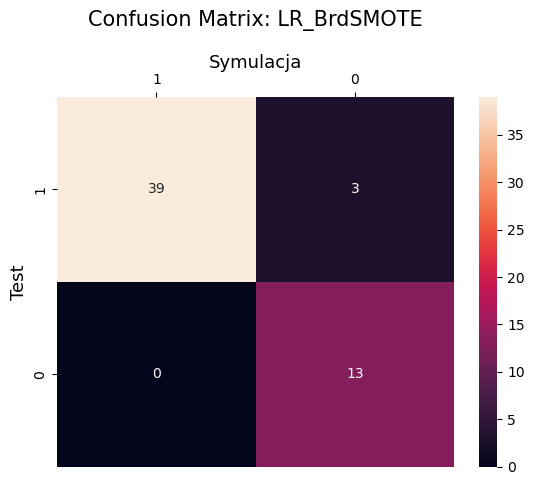

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


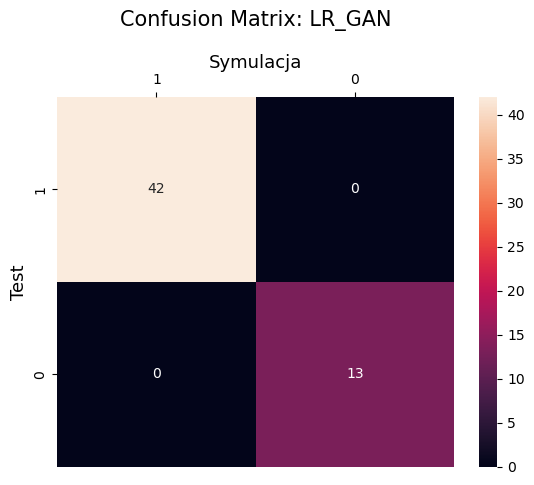

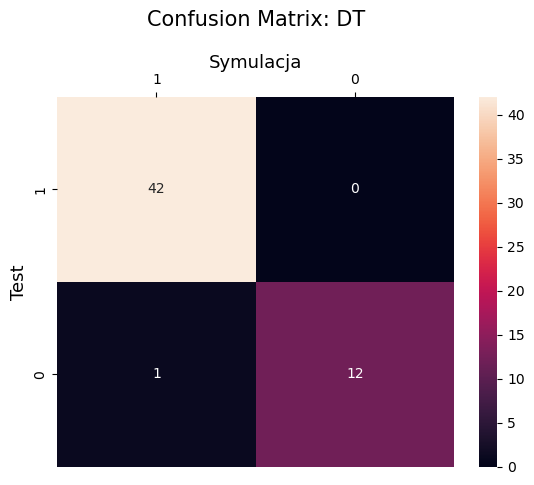

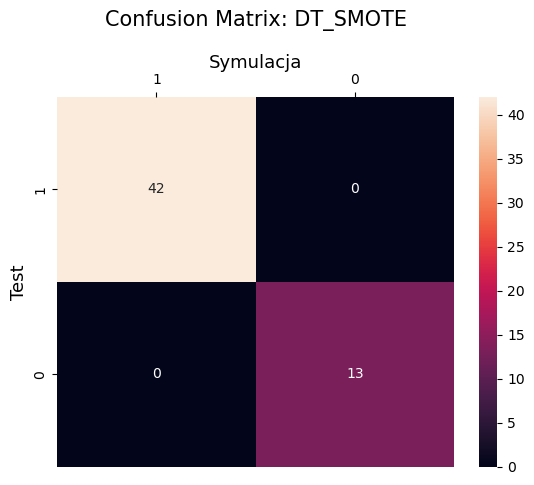

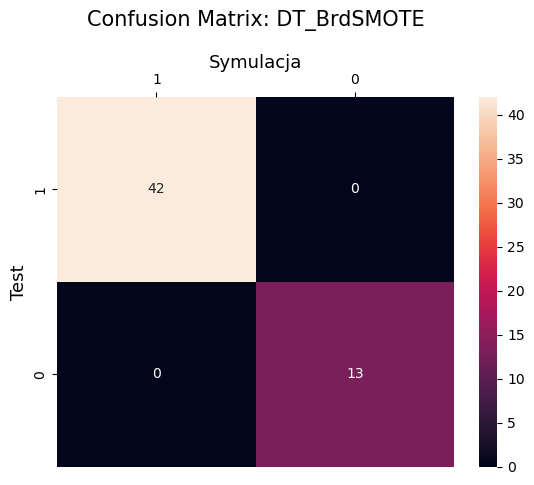

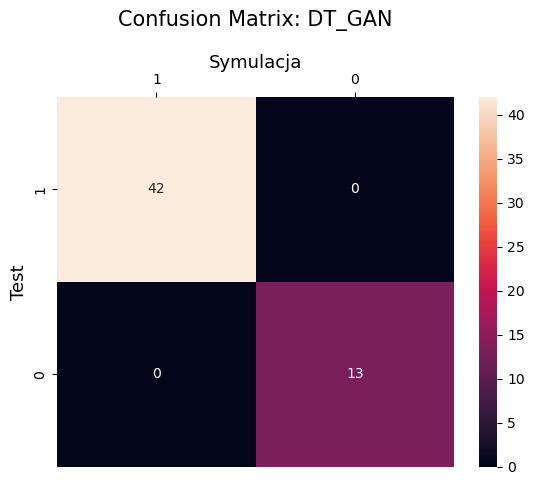

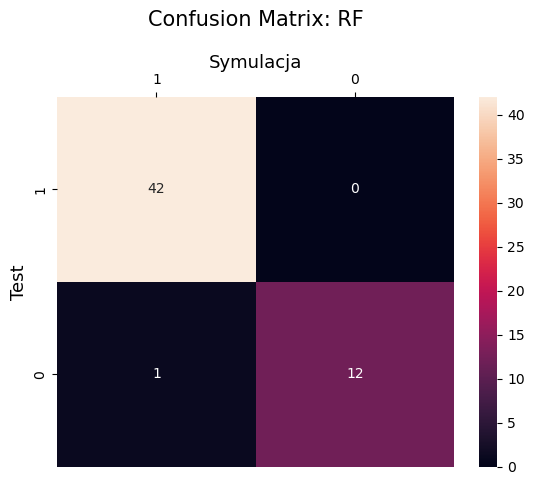

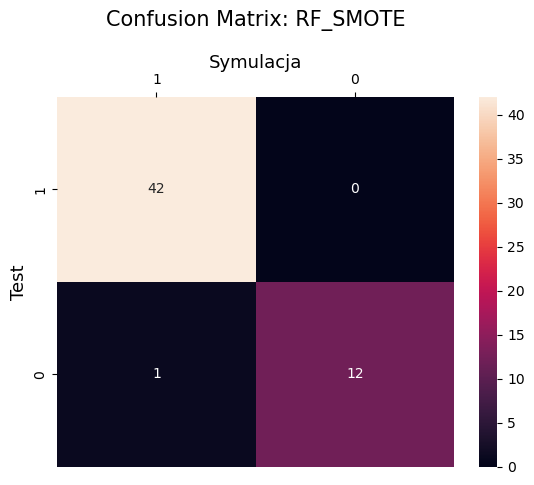

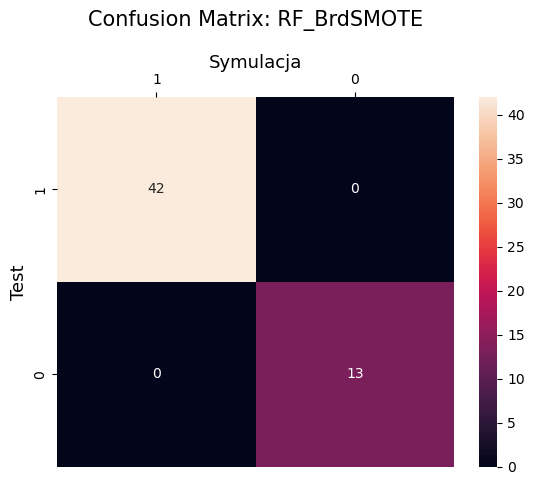

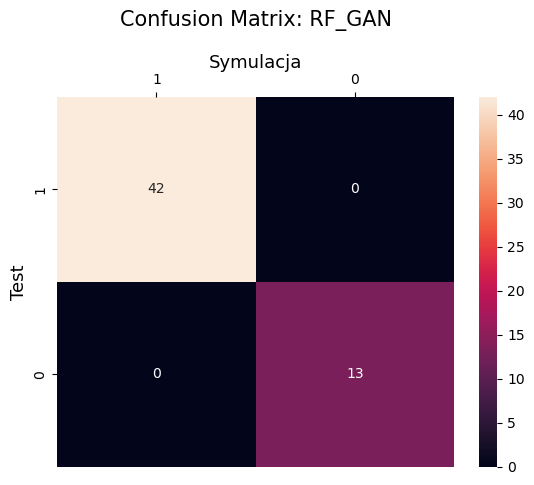

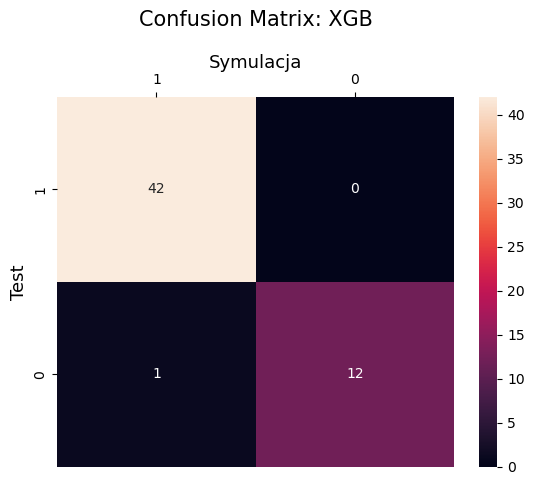

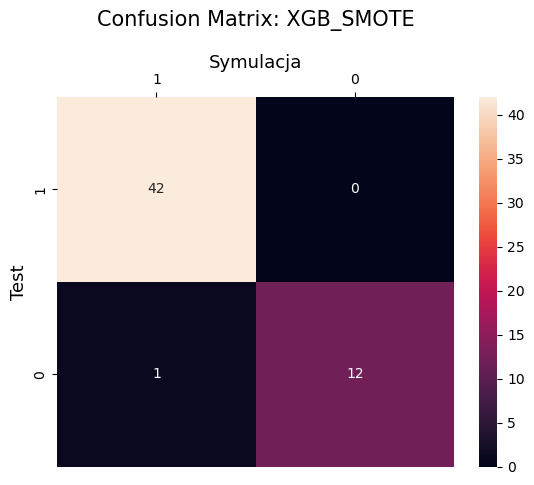

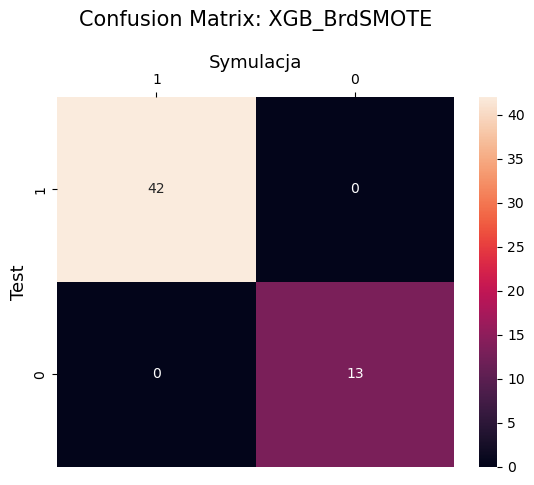

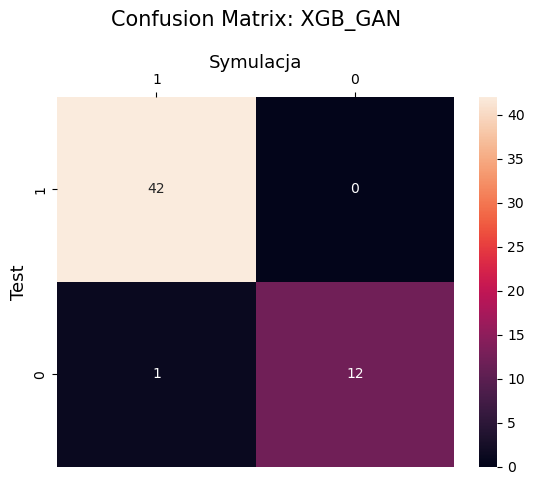

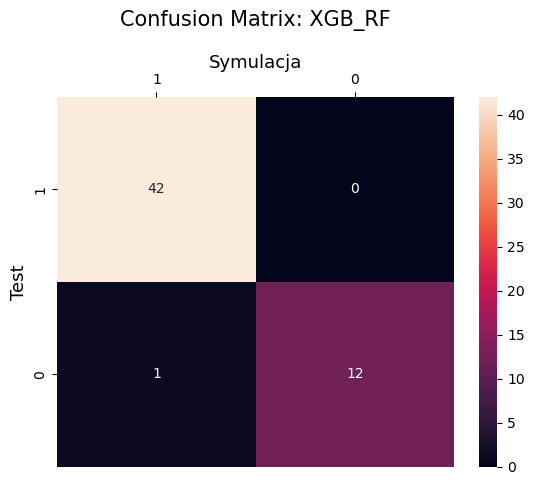

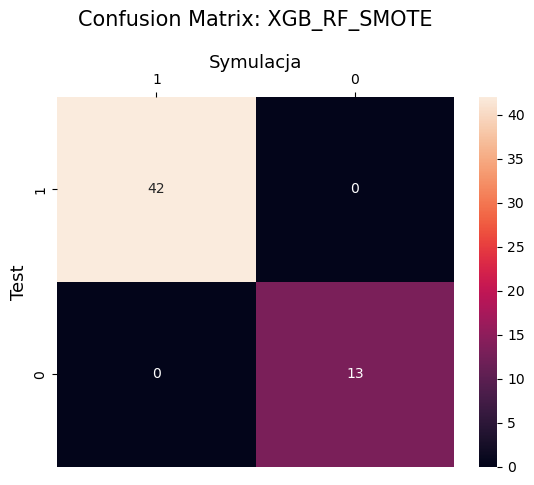

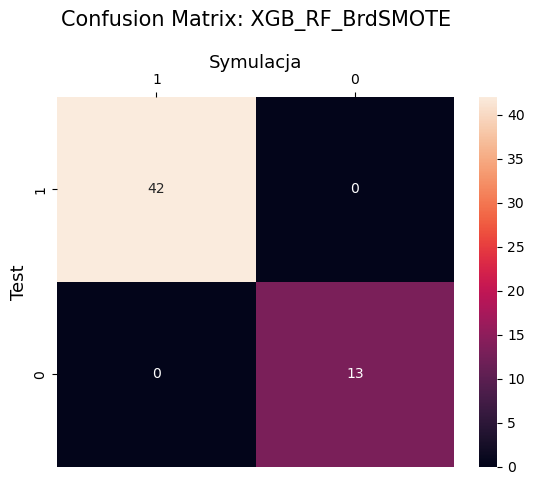

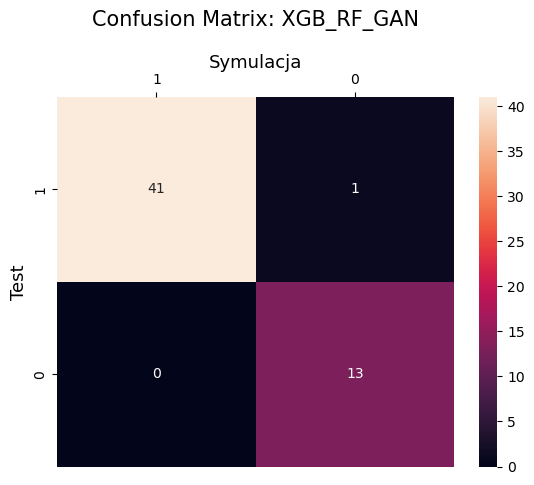

In [17]:
for model_name, model in models.items():
    
    # Pobieramy odpowiednie dane do trenowania dla bieżącego modelu
    X_train, y_train = fit_data[model_name]
    learned = model.fit(X_train, y_train)      
    y_pred = learned.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
            
    sns.heatmap(conf_mat, annot=True, xticklabels=["1", "0"], yticklabels=["1", "0"])
    plt.ylabel("Test", fontsize=13)
    plt.title(f"Confusion Matrix: {model_name}", fontsize=15, pad=20)
    plt.gca().xaxis.set_label_position("top")
    plt.xlabel("Symulacja", fontsize=13)
    plt.gca().xaxis.tick_top()
    plt.savefig(f'D:\\ml\\xgboost-main\\reports\\ssh\\conf matrix\\{model_name}.png', bbox_inches="tight", dpi=200)     
    plt.show()
    plt.close()  

## UNDERSAMPLING

In [21]:
#load data
""" smote_data = pd.read_csv("D:\\ml\\xgboost-main\\data\\ssh_logs\\smote_data.csv")
boarderline_smote_data = pd.read_csv("D:\\ml\\xgboost-main\\data\\ssh_logs\\boarderlinesmote_data.csv")
gan_data = pd.read_csv("D:\\ml\\xgboost-main\\data\\ssh_logs\\GAN_data.csv")
df_train = pd.read_csv("D:\\ml\\xgboost-main\\data\\ssh_logs\\original_data.csv")
X_test = pd.read_csv("D:\\ml\\xgboost-main\\data\\ssh_logs\\X_test.csv")
y_test = pd.read_csv("D:\\ml\\xgboost-main\\data\\ssh_logs\\y_test.csv")
X_test = X_test.drop(columns=["Unnamed: 0"])
y_test = y_test.drop(columns=["Unnamed: 0"]) """

#sum up df (GAN, SMOTE & borderlineSMOTE)
data1 = pd.concat([gan_data, smote_data], axis=0, ignore_index=True)
sum_data = pd.concat([boarderline_smote_data, data1], axis=0, ignore_index=True)
sum_data = sum_data.reset_index(drop=True) 

data2 = pd.concat([boarderline_smote_data, df_train], axis=0, ignore_index=True)
sum_data_NM = pd.concat([data1, data2], axis=0, ignore_index=True)
sum_data_NM = sum_data_NM.reset_index(drop=True) 

#df_train = df_train.drop(columns=["Unnamed: 0"])

# read file with data
#with open("RUS_ssh.pkl", "rb") as plik:
    #RUS_train = pickle.load(plik)

Sum up original: target
0    163
1     53
Name: count, dtype: int64
Sampling Strategy for SUM UP DATA: {1: 110, 0: 110}


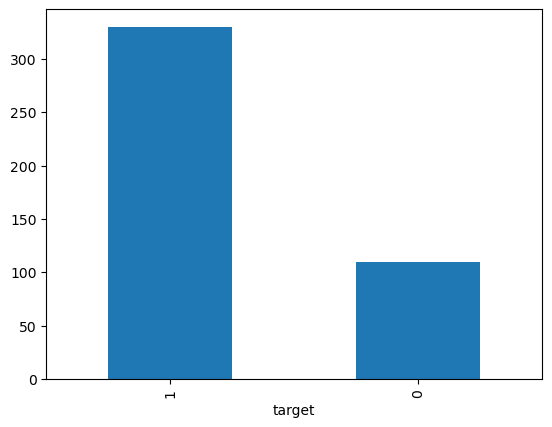

In [23]:
num_original = df_train["target"].value_counts()
print(f'Sum up original: {num_original}')
used_in_RUS = df_train[df_train["target"]==0]

#undersampling
RUS_train = {}

if num_original[0] > num_original[1]:
    #count sampling strategy
    under_samples = abs(num_original[0]-num_original[1])
    #copy only 0 from df_original 
    used_in_RUS = df_train[df_train["target"]==0]
    #used_in_RUS = used_in_RUS.drop(columns=["source"])
    count_zeros = used_in_RUS.sample(n=under_samples, random_state=42).copy()
    #count_zeros = count_zeros.drop(columns=["Unnamed: 0"])
    count_zeros_num = (count_zeros["target"] == 0).sum()
    strategy = {1: under_samples, 0: count_zeros_num}
    print(f"Sampling Strategy for SUM UP DATA: {strategy}")
    
    #split data
    RUS_data = pd.concat([sum_data, count_zeros], axis=0, ignore_index=True)
    y_under = RUS_data['target']
    X_under = RUS_data.drop(columns=["target", "source"]) 
    pd.Series(y_under).value_counts().plot.bar()
    
    #data add at the end which contains the rest 0 and 1 (~1373)
    merged = df_train.merge(count_zeros, on=df_train.columns.tolist(), how='left', indicator=True)
    rest_of_RUS = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
    
    for i in range(1, 101):
        RUS = RandomUnderSampler(random_state=i, sampling_strategy=strategy)
        X_res, y_res = RUS.fit_resample(X_under, y_under)
        X_rest = rest_of_RUS.drop(columns=["target", "source"])
        y_rest = rest_of_RUS["target"]
        X_res = pd.concat([X_res, X_rest], axis=0, ignore_index=True)
        y_res = pd.concat([y_res, y_rest], axis=0, ignore_index=True)
        RUS_train[f'X_RUS_{i}'] = X_res, y_res
        
else: 
    #count sampling strategy
    under_samples = abs(num_original[0]-num_original[1])
    #copy only 0 from df_original 
    used_in_RUS = df_train[df_train["target"]==0]
    count_ones = used_in_RUS.sample(n=under_samples, random_state=42).copy()
    count_ones_num = (df_train['target'] == 1).sum()
    strategy = {0: under_samples, 1: count_ones_num}
    print(f"Sampling Strategy for SUM UP DATA: {strategy}")
    
    #split data
    RUS_data = pd.concat([sum_data, count_ones], axis=0, ignore_index=True)
    y_under = RUS_data['target']
    X_under = RUS_data.drop(columns=["target", "source"]) 
    pd.Series(y_under).value_counts().plot.bar()
    
    #data add at the end which contains the rest 0 and 1 (~1373)
    merged = df_train.merge(count_ones, on=df_train.columns.tolist(), how='left', indicator=True)
    rest_of_RUS = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
    
    for i in range(1, 101):
        RUS = RandomUnderSampler(random_state=i, sampling_strategy=strategy)
        X_res, y_res = RUS.fit_resample(X_under, y_under)
        X_rest = rest_of_RUS.drop(columns=["target", "source"])
        y_rest = rest_of_RUS["target"]
        X_res = pd.concat([X_res, X_rest], axis=0, ignore_index=True)
        y_res = pd.concat([y_res, y_rest], axis=0, ignore_index=True)
        RUS_train[f'X_RUS_{i}'] = X_res, y_res


In [24]:
data2 = pd.concat([boarderline_smote_data, df_train], axis=0, ignore_index=True)
sum_data_NM = pd.concat([data1, data2], axis=0, ignore_index=True)
sum_data_NM = sum_data_NM.reset_index(drop=True) 

y_under_NM = sum_data_NM['target']
X_under_NM = sum_data_NM.drop(columns=["target", "source"]) 
NM = NearMiss()
X_NM, y_NM = NM.fit_resample(X_under_NM, y_under_NM)

In [25]:
models_under = {}

# Logistic Regression models
for i in range(1, 101):
    models_under[f"LR_RUS_{i}"] = LogisticRegression(max_iter=100, random_state=0)
models_under["LR_NM"] = LogisticRegression(max_iter=100, random_state=0)

# Decision Tree models
for i in range(1, 101):
    models_under[f"DT_RUS_{i}"] = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=30)
models_under["DT_NM"] = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=0)

# Random Forest models
for i in range(1, 101):
    models_under[f"RF_RUS_{i}"] = RandomForestClassifier(max_depth=8, min_samples_leaf=1, n_estimators=20, random_state=0)
models_under["RF_NM"] = RandomForestClassifier(max_depth=4, min_samples_leaf=1, n_estimators=100, random_state=40)

# XGBoost models
for i in range(1, 101):
    models_under[f"XGB_RUS_{i}"] = XGBClassifier(max_depth=4, subsample=1)
models_under["XGB_NM"] = XGBClassifier(max_depth=8, subsample=0.5)

# XGBoost RF models
for i in range(1, 101):
    models_under[f"XGB_RF_RUS_{i}"] = XGBRFClassifier(max_depth=4, n_estimators=20, subsample=0.5, random_state=0)
models_under["XGB_RF_NM"] = XGBRFClassifier(max_depth=8, n_estimators=20, subsample=0.6, random_state=20)

X_RUS = {}
y_RUS = {}

for i in range(1, 101):
    X_RUS[i], y_RUS[i] = RUS_train[f"X_RUS_{i}"]
    
fit_data_under = {}

#Logistic Regression
for i in range(1, 101):
    fit_data_under[f"LR_RUS_{i}"] = (X_RUS[i], y_RUS[i])
fit_data_under["LR_NM"] = (X_NM, y_NM)

#Decision Tree
for i in range(1, 101):
    fit_data_under[f"DT_RUS_{i}"] = (X_RUS[i], y_RUS[i])
fit_data_under["DT_NM"] = (X_NM, y_NM)

#Random Forest
for i in range(1, 101):
    fit_data_under[f"RF_RUS_{i}"] = (X_RUS[i], y_RUS[i])
fit_data_under["RF_NM"] = (X_NM, y_NM)

#XGBoost
for i in range(1, 101):
    fit_data_under[f"XGB_RUS_{i}"] = (X_RUS[i], y_RUS[i])
fit_data_under["XGB_NM"] = (X_NM, y_NM)

#XGBoost RF
for i in range(1, 101):
    fit_data_under[f"XGB_RF_RUS_{i}"] = (X_RUS[i], y_RUS[i])
fit_data_under["XGB_RF_NM"] = (X_NM, y_NM)

In [26]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
results_cross_mean_under=[]
results_cross_std_under=[]
goal = ['precision','f1','recall','accuracy']
path_files = ["D:\\ml\\xgboost-main\\reports\\ssh\\precision_under_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\ssh\\f1_under_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\ssh\\recall_under_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\ssh\\accuracy_under_metrics.txt"]

excel_file_cross = "D:\\ml\\xgboost-main\\reports\\ssh\\cross_under.xlsx"
excel_file_cross2 = "D:\\ml\\xgboost-main\\reports\\ssh\\cross_under_std.xlsx"
name_sheet1 = "Arkusz1"

for metrix1, path_file in zip(goal, path_files):
    for model_name, model in models_under.items():
        
        X_train, y_train = fit_data_under[model_name]
        cross_val_results = cross_val_score(model, X_train, y_train, cv=cv, scoring=metrix1, n_jobs=1)
        print(f"Learn: {metrix1} and model {model_name}")
        with open(path_file, "a+") as f:
            # Zapis wyników do pliku
            print(f'{model_name} Cross-Validation Results {metrix1}:\n {cross_val_results}', file=f)
            print(f'Mean {metrix1}: {cross_val_results.mean()}', file=f)
            print(f'Dev: {cross_val_results.std()}', file=f)
            print("\n", file=f)
        
        results_cross_mean_under.append({
        "Model": model_name,
        "Metric": metrix1,
        "Result": cross_val_results.mean()})
        results_cross_std_under.append({
        "Model": model_name,
        "Metric": metrix1,
        "Std": cross_val_results.std()})
        df_results_cross_under_mean = pd.DataFrame(results_cross_mean_under)
        df_results_cross_under_std = pd.DataFrame(results_cross_std_under)
        df_save_under_mean = df_results_cross_under_mean.pivot(index="Metric", columns="Model", values="Result")
        df_save_under_std = df_results_cross_under_std.pivot(index="Metric", columns="Model", values="Std")
        
        with pd.ExcelFile(excel_file_cross) as w:
            df_save_under_mean.to_excel(w, sheet_name=name_sheet1)
        with pd.ExcelFile(excel_file_cross2) as w1:
            df_save_under_std.to_excel(w1, sheet_name=name_sheet1)

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_RUS_1


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_RUS_2


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_RUS_3


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_RUS_4


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_RUS_5


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_RUS_6


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_RUS_7


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_RUS_8


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_RUS_9


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_RUS_10


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_NM
Learn: precision and model DT_RUS_1
Learn: precision and model DT_RUS_2
Learn: precision and model DT_RUS_3
Learn: precision and model DT_RUS_4
Learn: precision and model DT_RUS_5
Learn: precision and model DT_RUS_6
Learn: precision and model DT_RUS_7
Learn: precision and model DT_RUS_8
Learn: precision and model DT_RUS_9
Learn: precision and model DT_RUS_10
Learn: precision and model DT_NM
Learn: precision and model RF_RUS_1
Learn: precision and model RF_RUS_2
Learn: precision and model RF_RUS_3
Learn: precision and model RF_RUS_4
Learn: precision and model RF_RUS_5
Learn: precision and model RF_RUS_6
Learn: precision and model RF_RUS_7
Learn: precision and model RF_RUS_8
Learn: precision and model RF_RUS_9
Learn: precision and model RF_RUS_10
Learn: precision and model RF_NM
Learn: precision and model XGB_RUS_1
Learn: precision and model XGB_RUS_2
Learn: precision and model XGB_RUS_3
Learn: precision and model XGB_RUS_4
Learn: precision and model XGB_

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_RUS_1


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_RUS_2


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_RUS_3


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_RUS_4


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_RUS_5


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_RUS_6


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_RUS_7


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_RUS_8


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_RUS_9


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_RUS_10


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_NM
Learn: f1 and model DT_RUS_1
Learn: f1 and model DT_RUS_2
Learn: f1 and model DT_RUS_3
Learn: f1 and model DT_RUS_4
Learn: f1 and model DT_RUS_5
Learn: f1 and model DT_RUS_6
Learn: f1 and model DT_RUS_7
Learn: f1 and model DT_RUS_8
Learn: f1 and model DT_RUS_9
Learn: f1 and model DT_RUS_10
Learn: f1 and model DT_NM
Learn: f1 and model RF_RUS_1
Learn: f1 and model RF_RUS_2
Learn: f1 and model RF_RUS_3
Learn: f1 and model RF_RUS_4
Learn: f1 and model RF_RUS_5
Learn: f1 and model RF_RUS_6
Learn: f1 and model RF_RUS_7
Learn: f1 and model RF_RUS_8
Learn: f1 and model RF_RUS_9
Learn: f1 and model RF_RUS_10
Learn: f1 and model RF_NM
Learn: f1 and model XGB_RUS_1
Learn: f1 and model XGB_RUS_2
Learn: f1 and model XGB_RUS_3
Learn: f1 and model XGB_RUS_4
Learn: f1 and model XGB_RUS_5
Learn: f1 and model XGB_RUS_6
Learn: f1 and model XGB_RUS_7
Learn: f1 and model XGB_RUS_8
Learn: f1 and model XGB_RUS_9
Learn: f1 and model XGB_RUS_10
Learn: f1 and model XGB_NM
Learn: f1 an

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_RUS_1


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_RUS_2


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_RUS_3


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_RUS_4


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_RUS_5


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_RUS_6


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_RUS_7


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_RUS_8


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_RUS_9


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_RUS_10


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_NM
Learn: recall and model DT_RUS_1
Learn: recall and model DT_RUS_2
Learn: recall and model DT_RUS_3
Learn: recall and model DT_RUS_4
Learn: recall and model DT_RUS_5
Learn: recall and model DT_RUS_6
Learn: recall and model DT_RUS_7
Learn: recall and model DT_RUS_8
Learn: recall and model DT_RUS_9
Learn: recall and model DT_RUS_10
Learn: recall and model DT_NM
Learn: recall and model RF_RUS_1
Learn: recall and model RF_RUS_2
Learn: recall and model RF_RUS_3
Learn: recall and model RF_RUS_4
Learn: recall and model RF_RUS_5
Learn: recall and model RF_RUS_6
Learn: recall and model RF_RUS_7
Learn: recall and model RF_RUS_8
Learn: recall and model RF_RUS_9
Learn: recall and model RF_RUS_10
Learn: recall and model RF_NM
Learn: recall and model XGB_RUS_1
Learn: recall and model XGB_RUS_2
Learn: recall and model XGB_RUS_3
Learn: recall and model XGB_RUS_4
Learn: recall and model XGB_RUS_5
Learn: recall and model XGB_RUS_6
Learn: recall and model XGB_RUS_7
Learn: rec

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_RUS_1


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_RUS_2


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_RUS_3


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_RUS_4


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_RUS_5


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_RUS_6


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_RUS_7


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_RUS_8


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_RUS_9


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_RUS_10


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_NM
Learn: accuracy and model DT_RUS_1
Learn: accuracy and model DT_RUS_2
Learn: accuracy and model DT_RUS_3
Learn: accuracy and model DT_RUS_4
Learn: accuracy and model DT_RUS_5
Learn: accuracy and model DT_RUS_6
Learn: accuracy and model DT_RUS_7
Learn: accuracy and model DT_RUS_8
Learn: accuracy and model DT_RUS_9
Learn: accuracy and model DT_RUS_10
Learn: accuracy and model DT_NM
Learn: accuracy and model RF_RUS_1
Learn: accuracy and model RF_RUS_2
Learn: accuracy and model RF_RUS_3
Learn: accuracy and model RF_RUS_4
Learn: accuracy and model RF_RUS_5
Learn: accuracy and model RF_RUS_6
Learn: accuracy and model RF_RUS_7
Learn: accuracy and model RF_RUS_8
Learn: accuracy and model RF_RUS_9
Learn: accuracy and model RF_RUS_10
Learn: accuracy and model RF_NM
Learn: accuracy and model XGB_RUS_1
Learn: accuracy and model XGB_RUS_2
Learn: accuracy and model XGB_RUS_3
Learn: accuracy and model XGB_RUS_4
Learn: accuracy and model XGB_RUS_5
Learn: accuracy and mo

In [27]:
for model_name, model in models_under.items():  
    name = f"D:\\ml\\xgboost-main\\models\\ssh\\{model_name}_under.joblib"  
    dump(model, name)
    print(f"Model {model_name} saved in: {name}")

Model LR_RUS_1 saved in: D:\ml\xgboost-main\models\ssh\LR_RUS_1_under.joblib
Model LR_RUS_2 saved in: D:\ml\xgboost-main\models\ssh\LR_RUS_2_under.joblib
Model LR_RUS_3 saved in: D:\ml\xgboost-main\models\ssh\LR_RUS_3_under.joblib
Model LR_RUS_4 saved in: D:\ml\xgboost-main\models\ssh\LR_RUS_4_under.joblib
Model LR_RUS_5 saved in: D:\ml\xgboost-main\models\ssh\LR_RUS_5_under.joblib
Model LR_RUS_6 saved in: D:\ml\xgboost-main\models\ssh\LR_RUS_6_under.joblib
Model LR_RUS_7 saved in: D:\ml\xgboost-main\models\ssh\LR_RUS_7_under.joblib
Model LR_RUS_8 saved in: D:\ml\xgboost-main\models\ssh\LR_RUS_8_under.joblib
Model LR_RUS_9 saved in: D:\ml\xgboost-main\models\ssh\LR_RUS_9_under.joblib
Model LR_RUS_10 saved in: D:\ml\xgboost-main\models\ssh\LR_RUS_10_under.joblib
Model LR_NM saved in: D:\ml\xgboost-main\models\ssh\LR_NM_under.joblib
Model DT_RUS_1 saved in: D:\ml\xgboost-main\models\ssh\DT_RUS_1_under.joblib
Model DT_RUS_2 saved in: D:\ml\xgboost-main\models\ssh\DT_RUS_2_under.joblib
Mod

In [28]:
with open("D:\\ml\\xgboost-main\\data\\ssh_logs\\RUS_train.pkl", "wb") as plik:
    pickle.dump(RUS_train, plik)

In [29]:
data_resampled = {    
    "RUS_1" : (X_RUS_1, y_RUS_1),
    "RUS_2" : (X_RUS_2, y_RUS_2),
    "RUS_3" : (X_RUS_3, y_RUS_3),
    "RUS_4" : (X_RUS_4, y_RUS_4),
    "RUS_5" : (X_RUS_5, y_RUS_5),
    "RUS_6" : (X_RUS_6, y_RUS_6),
    "RUS_7" : (X_RUS_7, y_RUS_7),
    "RUS_8" : (X_RUS_8, y_RUS_8),
    "RUS_9" : (X_RUS_9, y_RUS_9),
    "RUS_10" : (X_RUS_10, y_RUS_10),
    
    "NM" : (X_NM, y_NM)}
path_file = "D:\\ml\\xgboost-main\\reports\\ssh\\distribution.txt"
path_excel = "D:\\ml\\xgboost-main\\reports\\ssh\\distribution.xlsx"
percentage = []

with open (path_file, "a+") as f:
    print("Data Distribution", file=f)
    print(sum_data_NM['source'].value_counts(), file=f)
    print("\n", file=f)
    
for data_name, data_cal in data_resampled.items():
    X_1, y_1 = data_resampled[data_name]
    data_cal = pd.concat([X_1, y_1], axis=1)
    print(data_name)
    print(data_cal.head())
    data_cal = data_cal.reset_index(drop=True)
    sum_data_NM = sum_data_NM.reset_index(drop=True)
    #data_cal = pd.merge(data_cal, sum_data_NM[['source']], how='left', left_index=True, right_index=True)          #Dopasowanie kolumn w `data` i `data_cal`
    comparison = pd.merge(data_cal, sum_data_NM, how='outer', indicator=True)                  #Połączenie zbiorów danych w celu identyfikacji unikalnych wierszy

#rozklad danych
    in_both = comparison[comparison['_merge'] == 'both']       #wiersze obecne w obu zbiorach
    training_source_distribution = in_both['source'].value_counts()

    source_percentage = (training_source_distribution / training_source_distribution.sum() * 100).fillna(0)     #procentowego udziału danych użytych do treningu

#procentowego udziału dla poszczególnych grup
    percent_original = source_percentage.get('original', 0)
    percent_gan = source_percentage.get('gan', 0)
    percent_boarderline = source_percentage.get('borderline smote', 0)
    percent_smote = source_percentage.get('smote', 0)

#wyświetlenie wyników
    with open (path_file, "a+") as f:
        print(f"{data_name}", file=f)
        print(f"\nRozklad `source` w zbiorze treningowym {data_name}:", file=f)
        print(training_source_distribution, file=f)
        print(f"\nProcent uzycia danych do treningu {data_name} dla kazdej wartosci `source`:", file=f)
        print(f"Oryginal: {percent_original}", file=f)
        print(f"GAN: {percent_gan}", file=f)
        print(f"Boarderline SMOTE: {percent_boarderline}", file=f)
        print(f"SMOTE: {percent_smote}", file=f)
        print("\n", file=f)
        
    percentage.append({
        "Data Name": data_name,
        "Original (%)": percent_original,
        "GAN (%)": percent_gan,
        "Boarderline SMOTE (%)": percent_boarderline,
        "SMOTE (%)": percent_smote
    })
    df_perce = pd.DataFrame(percentage)
    df_perce.to_excel(path_excel, index=False, sheet_name="Source_Distribution")


RUS_1
   is_private  is_failure  is_root  is_valid  not_valid_count  ip_failure  \
0           1           1        0         1                0           1   
1           1           1        0         1                0           8   
2           1           1        0         1                0           2   
3           1           0        0         1                0           0   
4           1           1        0         1                0           4   

   ip_success  no_failure  first  td  target  
0           1           2      0  61       0  
1          21          22      0  78       0  
2           0           3      0  11       0  
3          13           0      0  29       0  
4          14           6      0   4       0  
RUS_2
   is_private  is_failure  is_root  is_valid  not_valid_count  ip_failure  \
0           1           1        0         1                0           2   
1           1           1        0         0                7           7   
2           

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


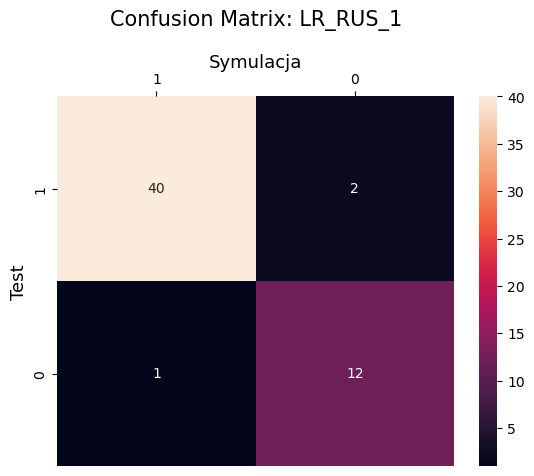

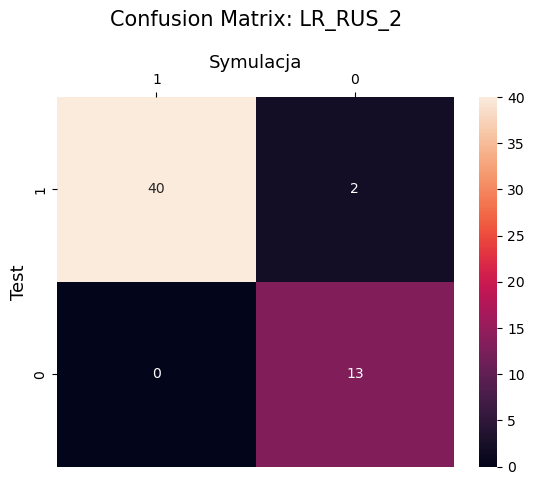

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


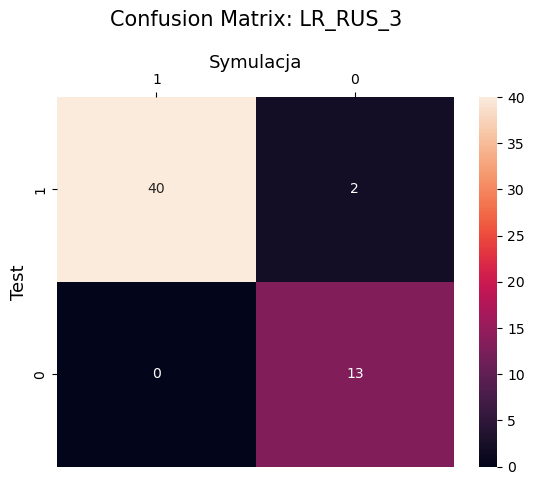

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


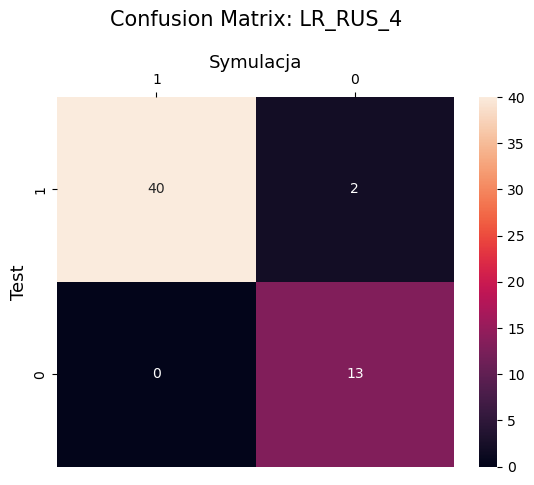

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


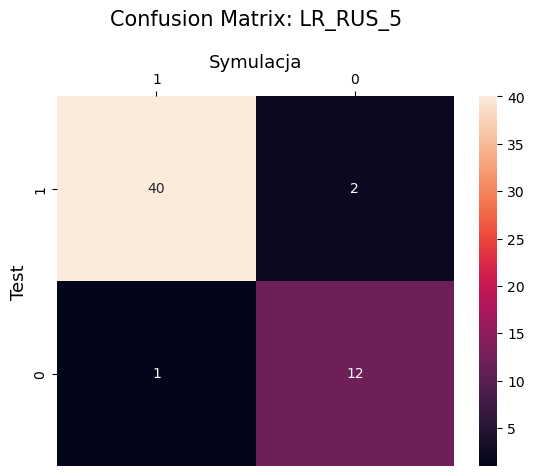

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


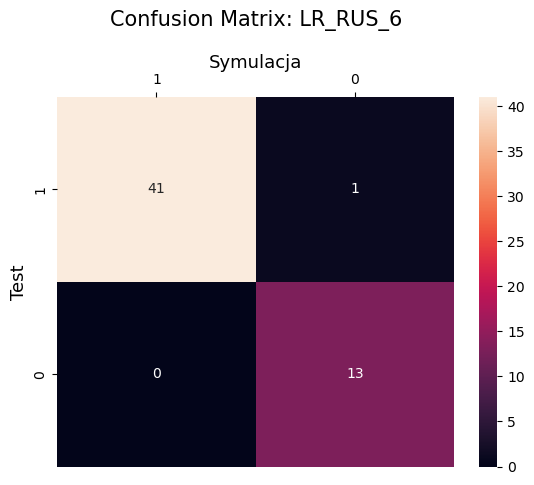

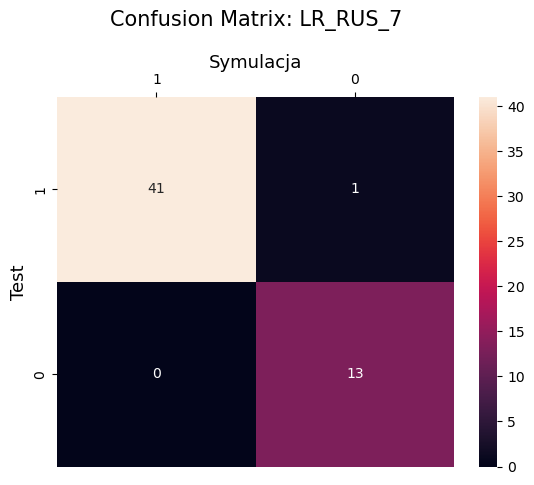

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


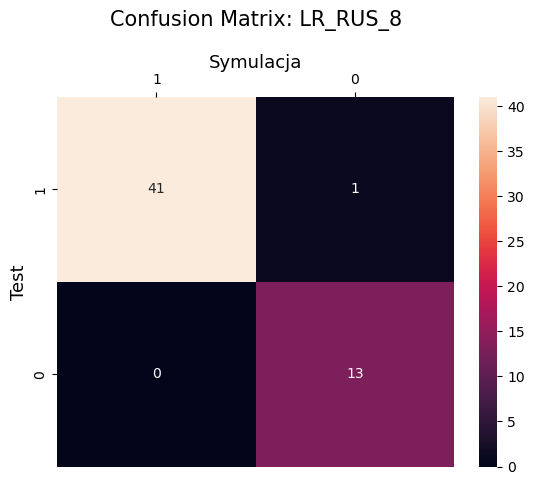

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


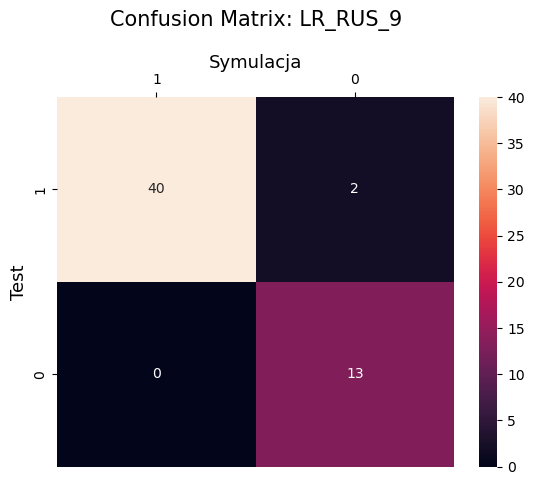

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


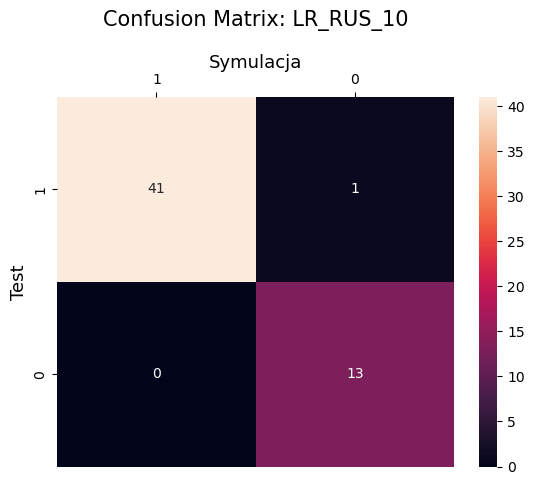

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


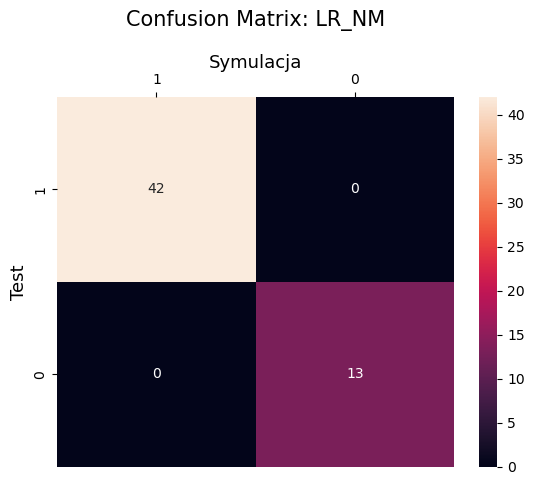

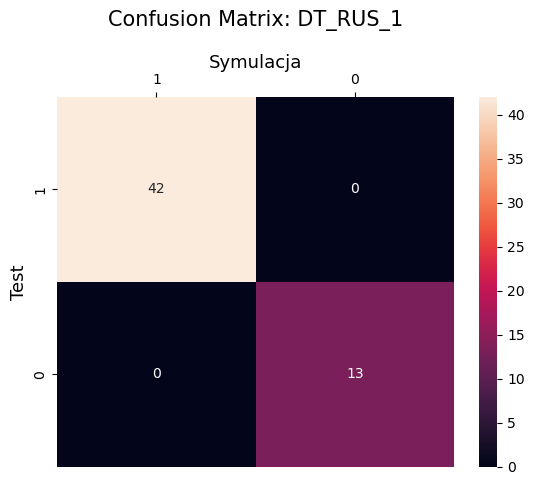

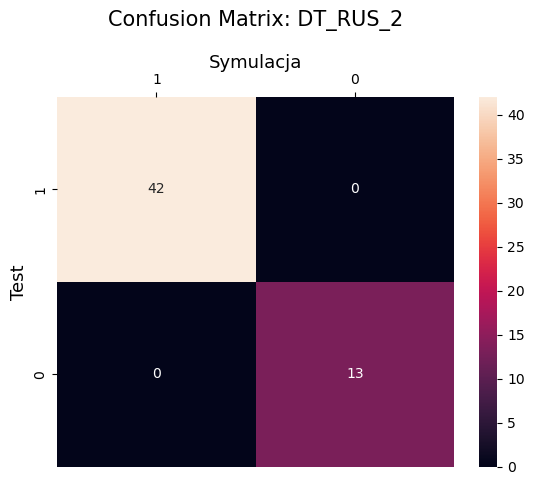

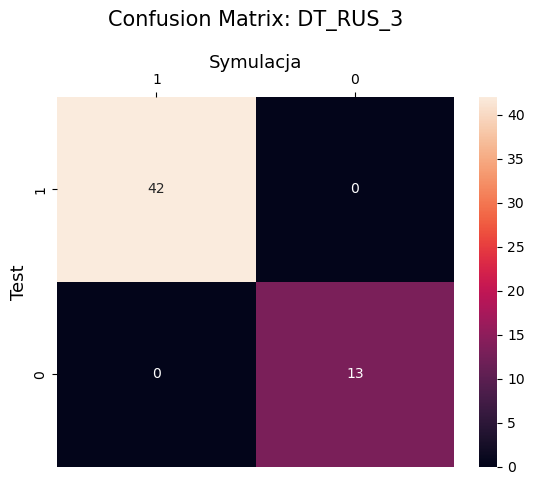

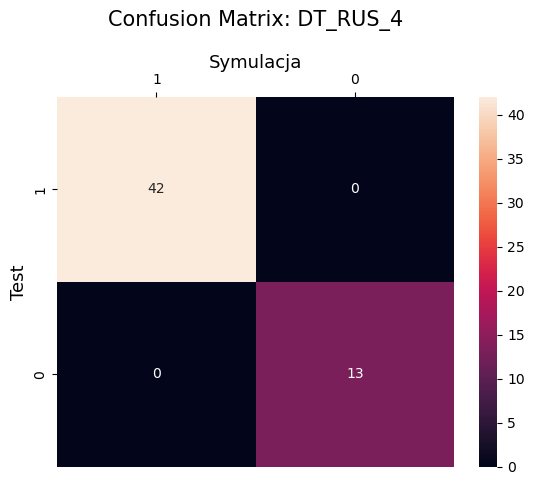

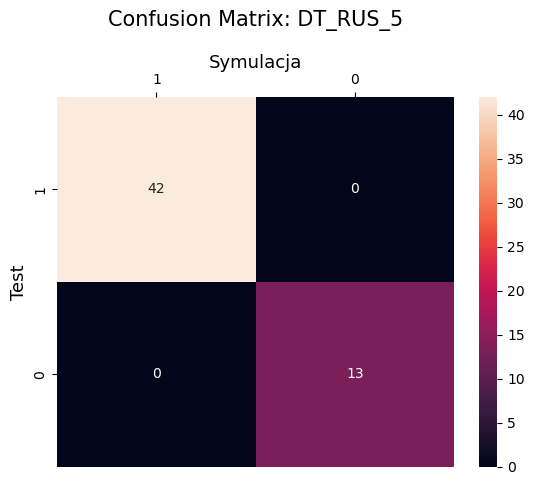

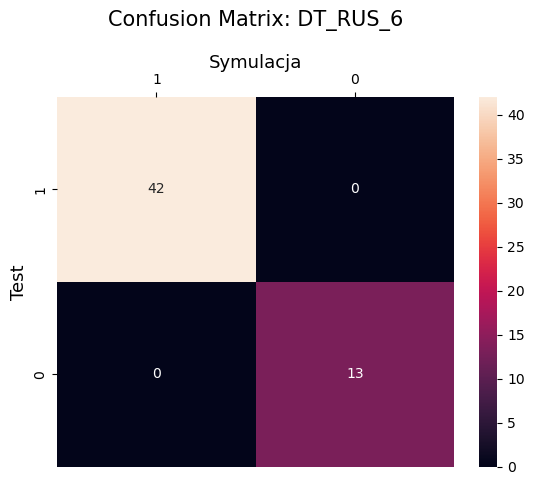

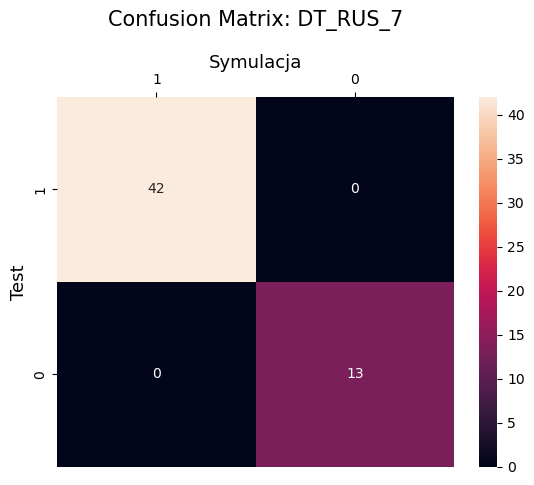

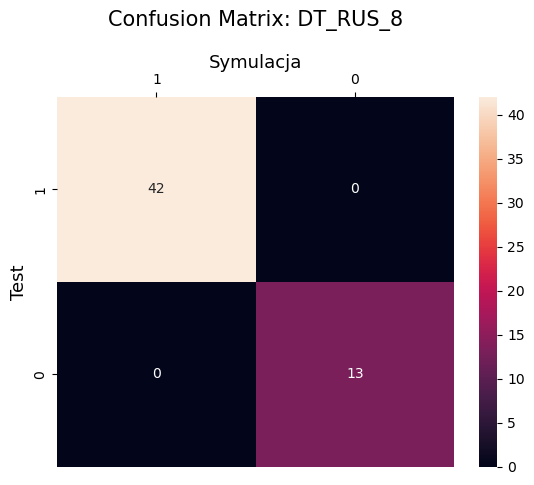

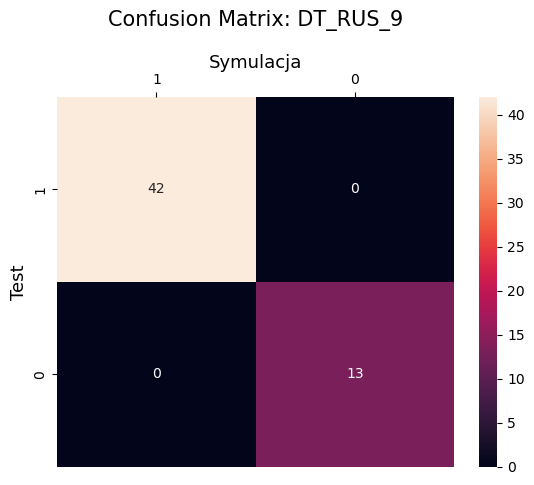

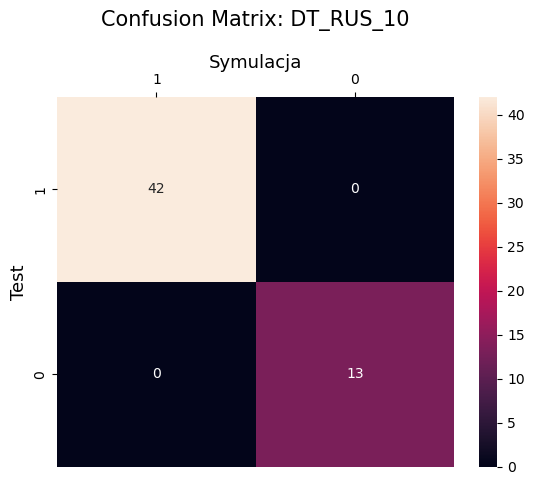

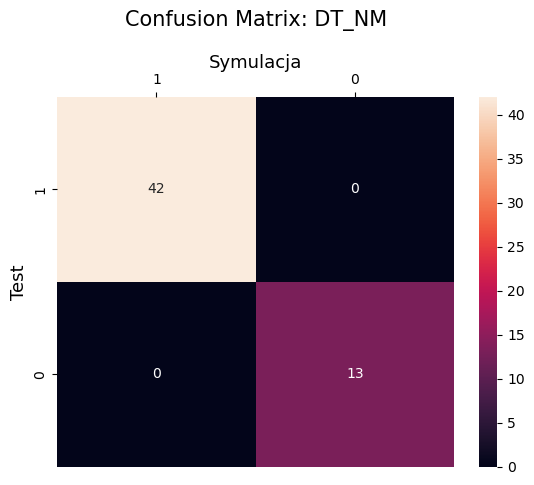

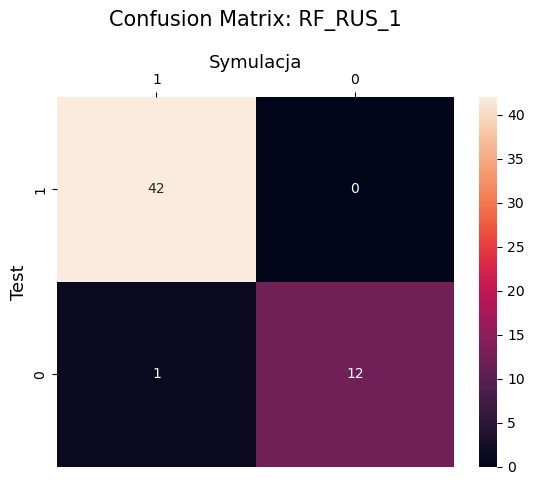

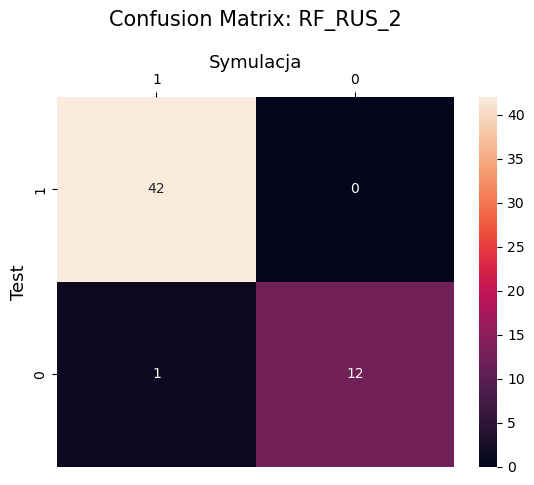

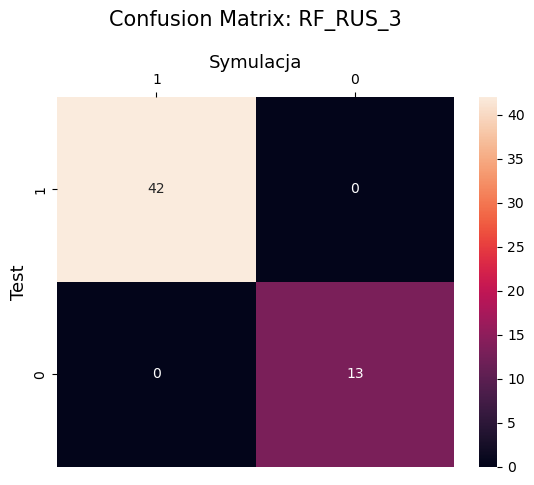

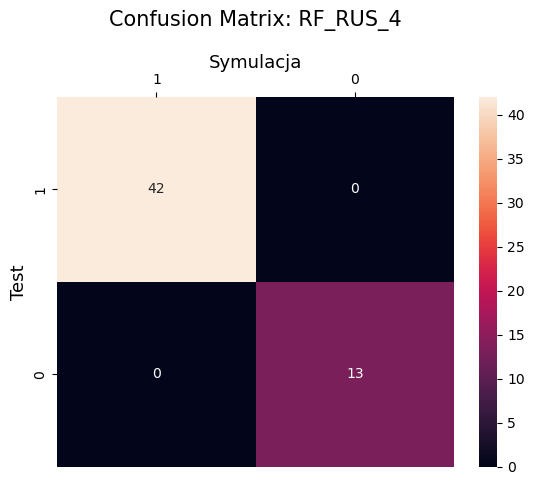

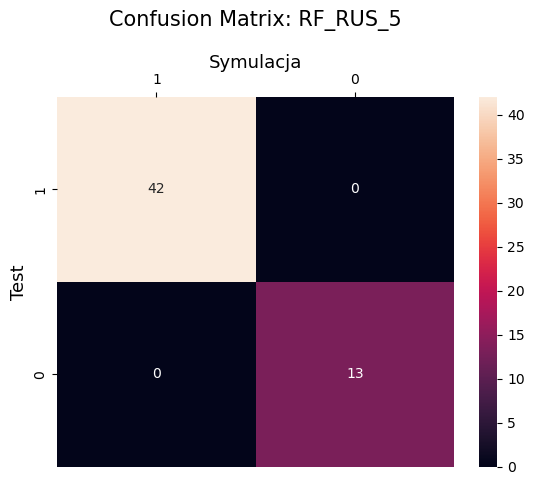

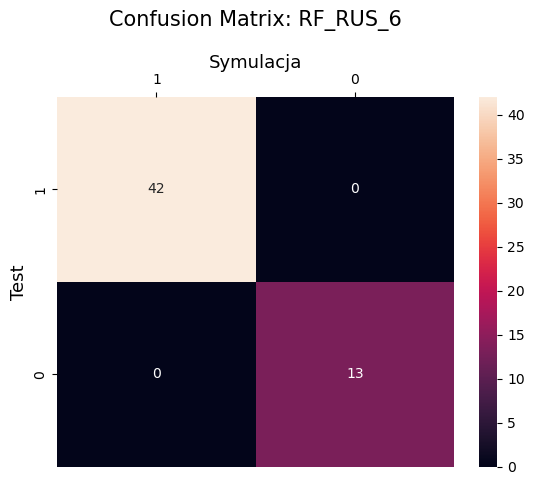

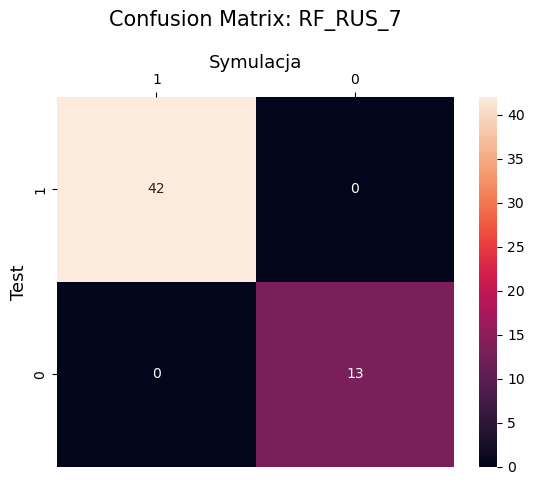

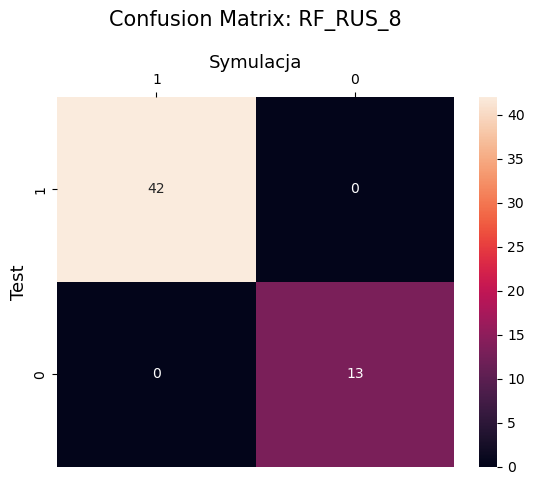

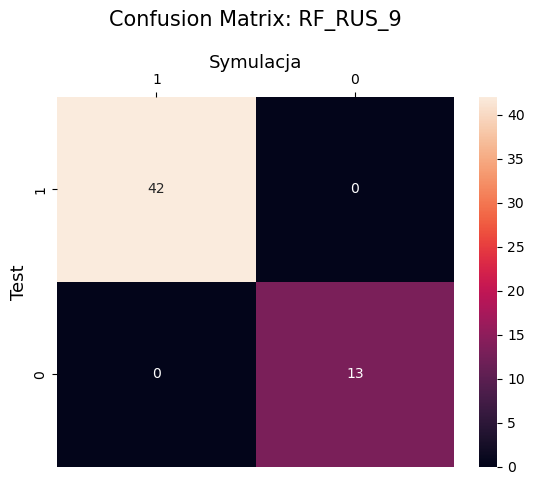

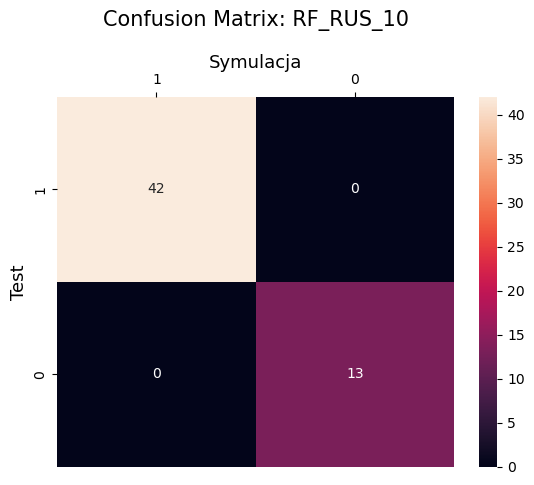

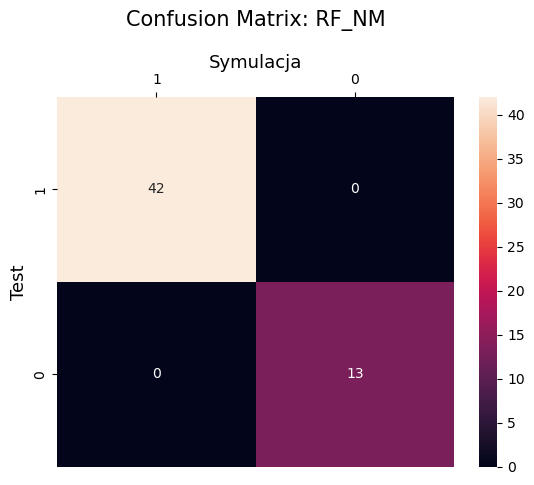

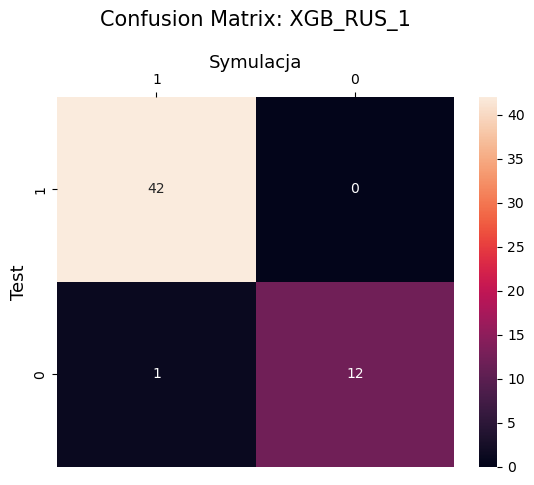

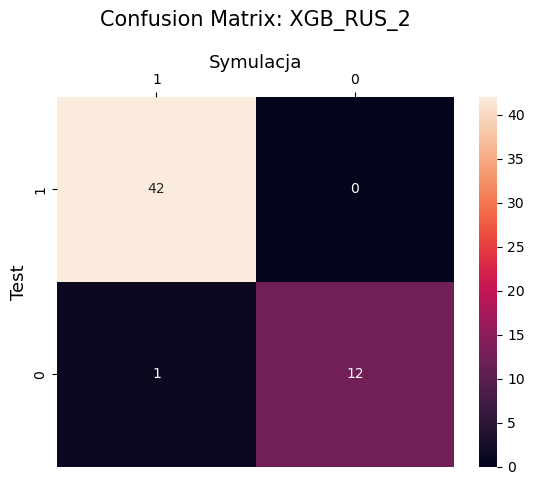

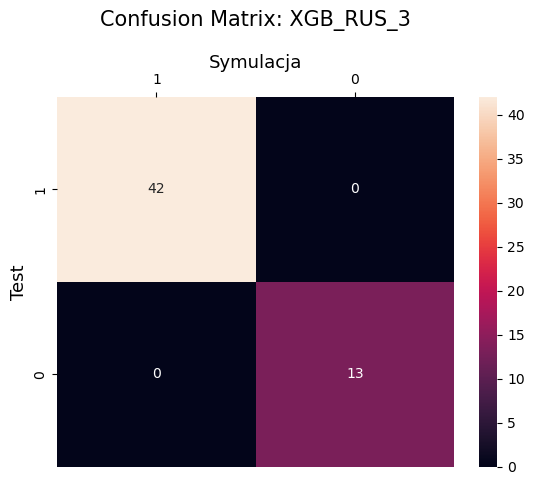

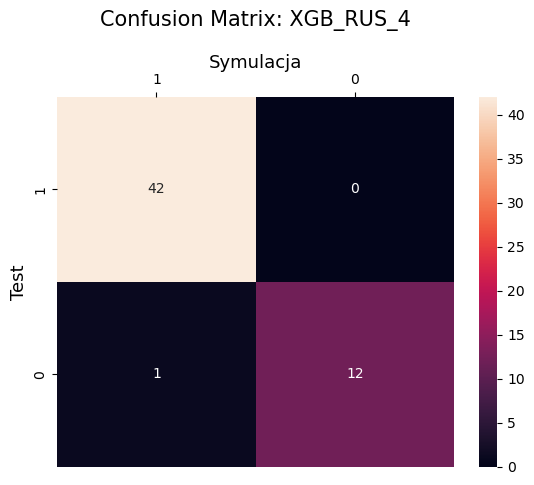

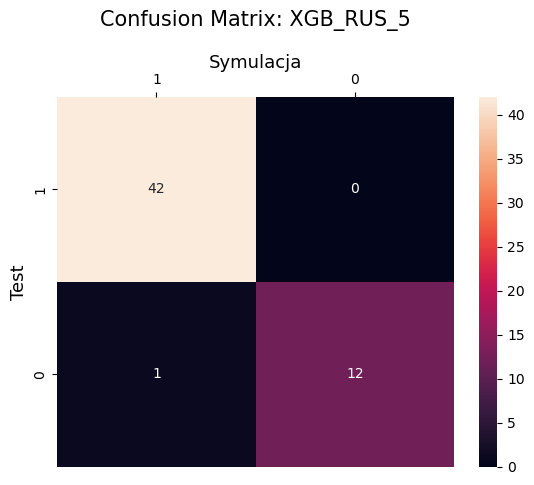

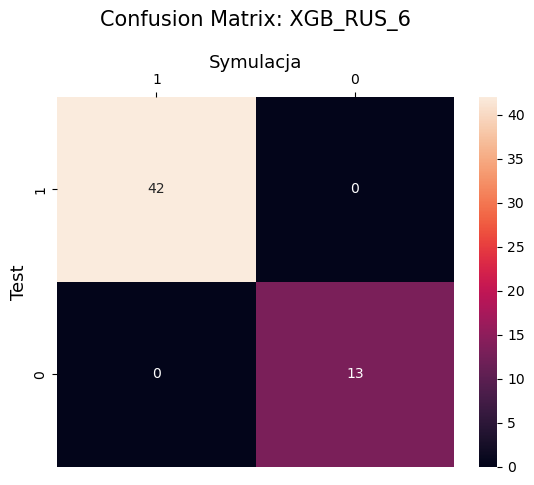

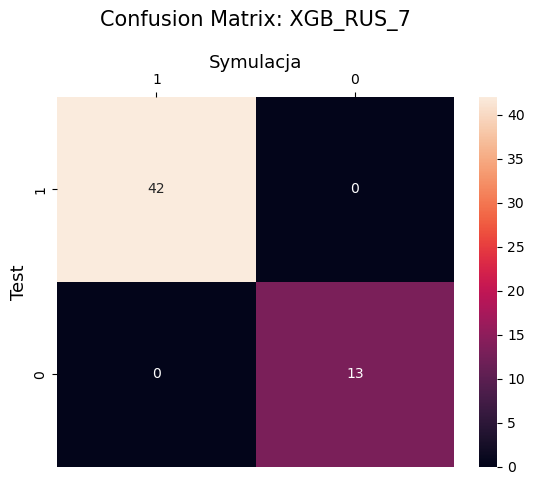

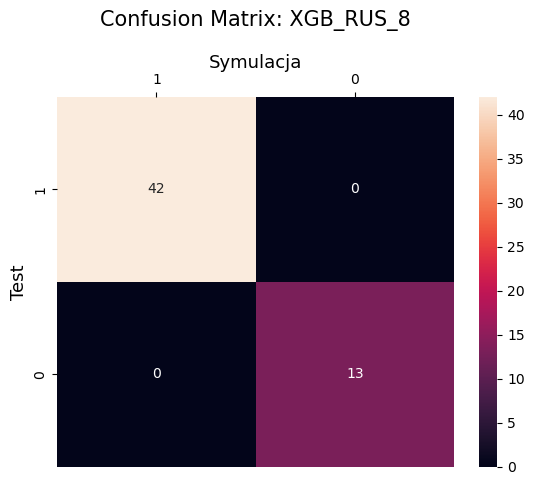

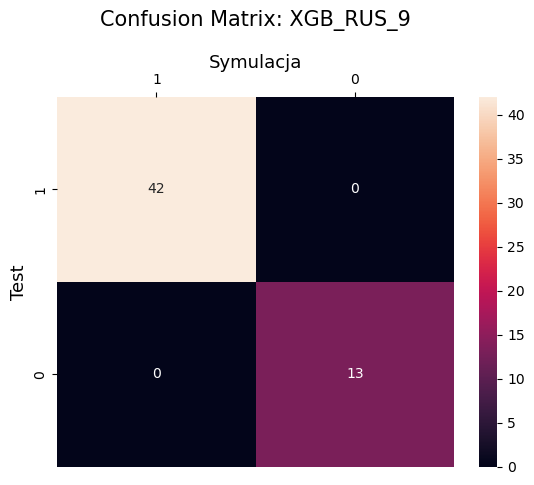

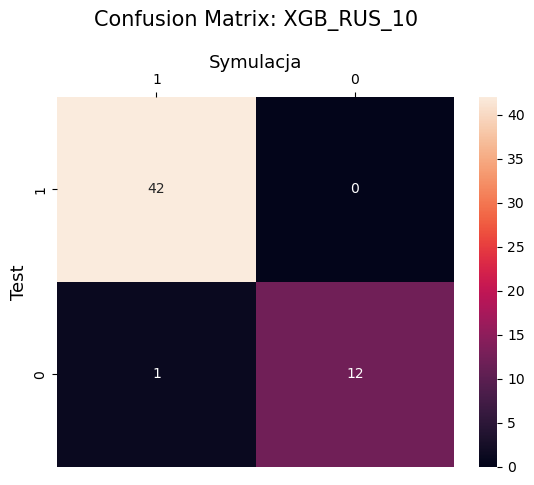

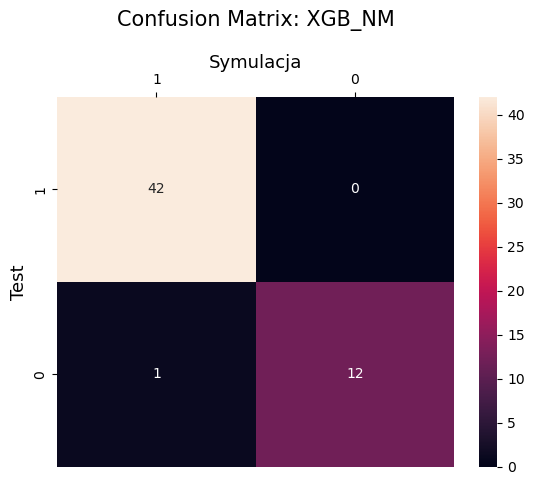

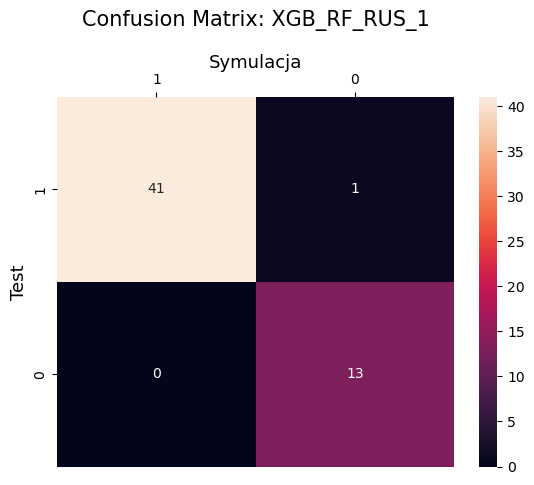

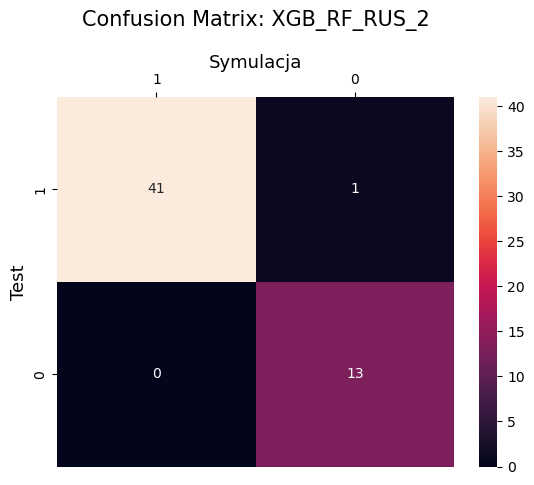

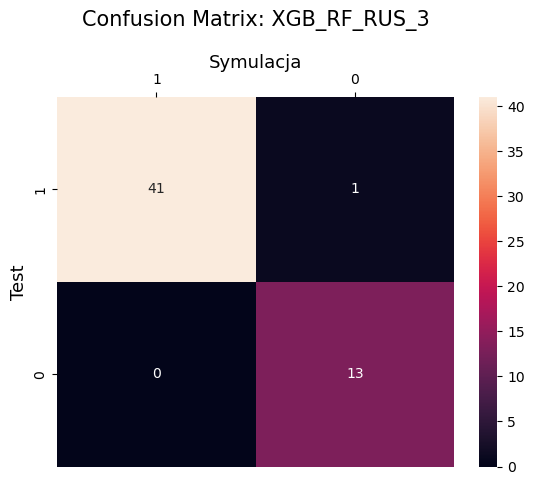

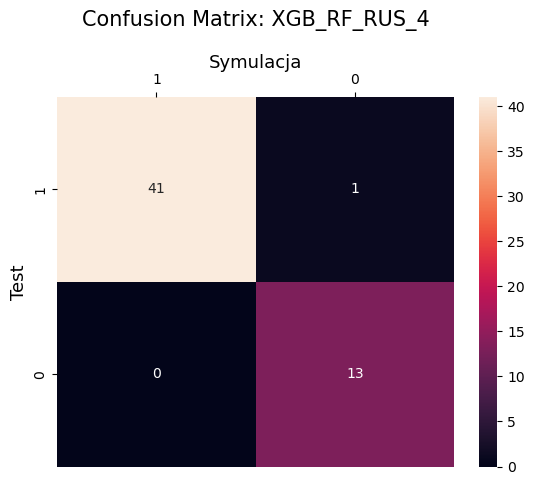

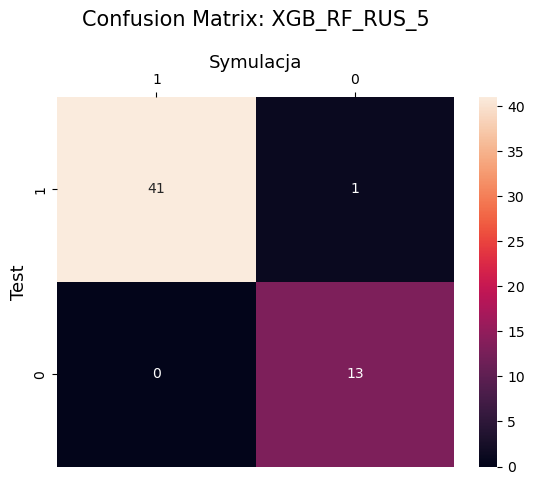

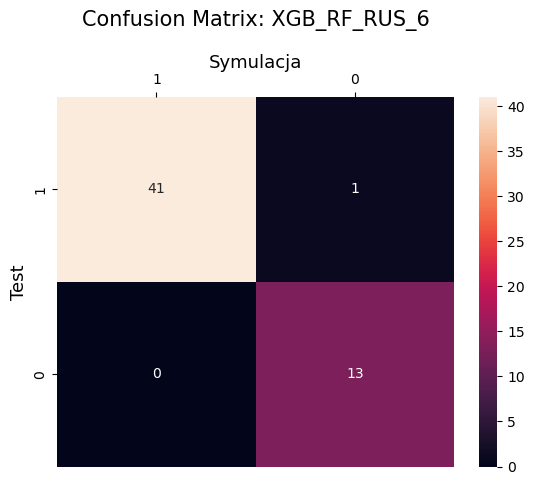

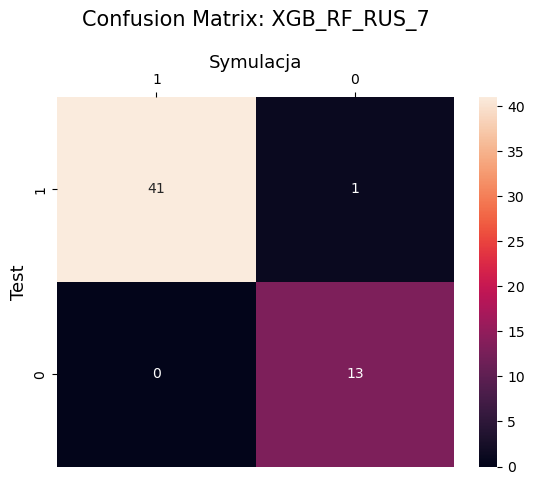

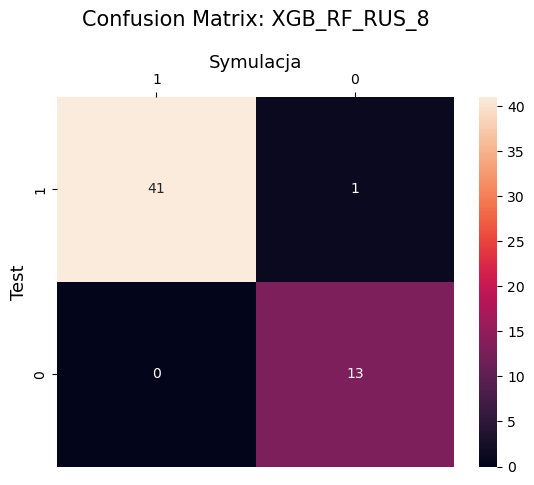

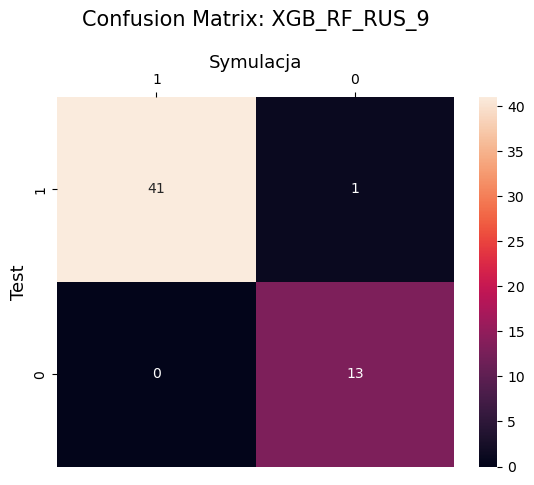

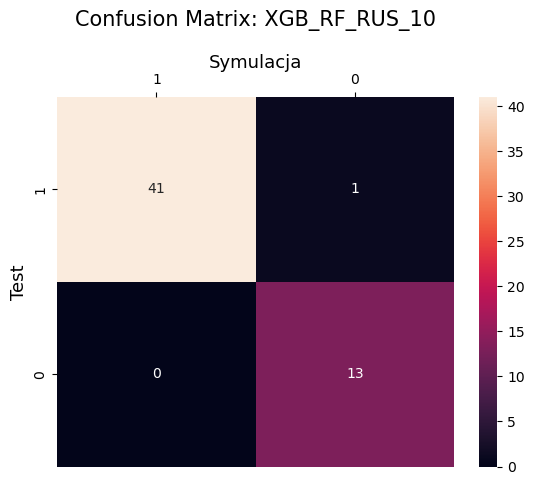

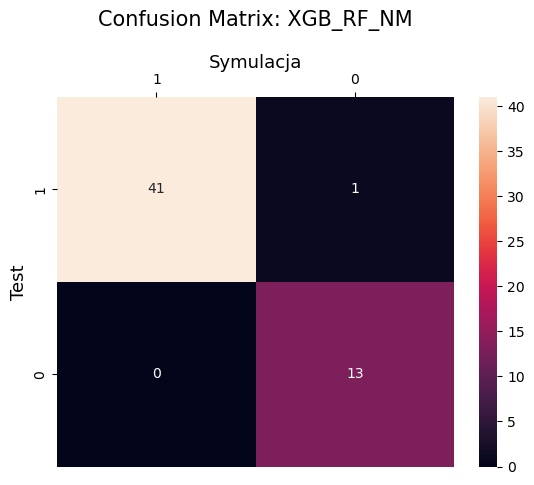

In [31]:
for model_name, model in models_under.items():
    
    # Pobieramy odpowiednie dane do trenowania dla bieżącego modelu
    X_train, y_train = fit_data_under[model_name]
    learned = model.fit(X_train, y_train)      
    y_pred = learned.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
            
    sns.heatmap(conf_mat, annot=True, xticklabels=["1", "0"], yticklabels=["1", "0"])
    plt.ylabel("Test", fontsize=13)
    plt.title(f"Confusion Matrix: {model_name}", fontsize=15, pad=20)
    plt.gca().xaxis.set_label_position("top")
    plt.xlabel("Symulacja", fontsize=13)
    plt.gca().xaxis.tick_top()
    plt.savefig(f'D:\\ml\\xgboost-main\\reports\\ssh\\conf matrix under\\{model_name}.png', bbox_inches="tight", dpi=200)     
    plt.show()
    plt.close()  